# III. Filter data using Cordoni's algorithm

> Francisco Carrasco Varela - Pontificia Universidad Católica de Chile (PUC) - ffcarrasco@uc.cl ⭐

<center>
<mark>The following Jupyter Notebook is used to extract and work with Gaia DR3 data<br>
    (and other data releases) </mark>
</center>

In [1]:
##################################################
object_name = "NGC6093"  # <--- OBJECT NAME FROM PREVIOUS STEPS, EDITABLE

Import libraries needed

In [2]:
# Import all the libraries we will need

%matplotlib inline
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import numpy as np
import os
from astropy.io import ascii
from astropy.table import vstack, Table
from tabulate import tabulate
from numpy import ones
from numpy import vstack as npvstack
from numpy.linalg import lstsq
from matplotlib.offsetbox import AnchoredText

import sys
sys.path.insert(0, '../Scripts/')
import Parameters as PR

# 1 -. Creating Bins and extracting parameters

The following step on this Notebook will follow the procedure given by [Cordoni et. al (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...869..139C/abstract) and [Cordoni et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract) applied for Gaia DR2, this method avoid fake members using multiple filters. More recently this method has been used by [Cordoni et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...672A..29C/abstract) for Gaia DR3.

## 1.1 -. Reading Previous Data

First of all, read the data from previous steps. If you do not have done previous steps, please follow the previous instructions before proceeding with this step; since some files generated by previous steps are needed. I.e., you must run previous steps before continuing.

In [3]:
### This cell gets the properties for OBJ_NAME if it is listed in files contained in '../ObjectData'

@dataclass(kw_only=True)
class astroStudy:
    """
    Studies where the data is extracted from
    """
    authors: list[str]
    year: int
    magazine: str
    vol: str
    page: str
    study_url: str
    data_dir: str

    def show_study(self) -> str:
        """
        Prints the classic "Author & Author 2 (2024)" or "Author et al. (2024)"
        """
        if len(self.authors) <= 2:
            author1 = self.authors[0].split(',')[0]
            author2 = self.authors[1].split(',')[0]
            return f"{author1} & {author2} ({self.year}, {self.magazine}, {self.vol}, {self.page})"
        else:
            first_author = self.authors[0].split()[0]
            return f"{first_author} et al. ({self.year}, {self.magazine}, {self.vol}, {self.page})"

        
@dataclass(kw_only=True, frozen=True)
class VasilievObject:
    """
    Create a data structure for data obtained from Vasiliev & Baumgardt (2021, MNRAS, 505, 5978V)
    """
    name: str = '' # object name
    opt_name: str = ''# optional name if available
    ra: float  # deg J2000
    dec:float  # deg J2000
    pmra:float  # mas/yr
    e_pmra:float  # mas/yr
    pmdec:float  # mas/yr
    e_pmdec:float  # mas/yr
    parallax:float  # mas
    e_parallax:float  # mas
    rscale:float # arcmin
    nstar:int  # number of Gaia-detected cluster stars

        
def get_extra_object_info_globular_cluster(obj_name_selected):
    """
    Request Globular Cluster data from Vasiliev & Baumgardt (2021, MNRAS, 505, 5978V) if available
    """
    #p = log.progress(f"{colors['L_GREEN']}Searching data for Globular Clusters{colors['NC']}")
    # Check data from Vasiliev & Baumgardt (2021, MNRAS, 505, 5978V)
    vasiliev_baumgardt_study = astroStudy(authors=["Vasiliev, E.", "Baumgardt, H."],
                                         year=2021, magazine="MNRAS",
                                         vol="505", page="597V",
                                         study_url='https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5978V/abstract',
                                         data_dir='../ObservedData/Vasiliev_and_Baumgardt_2021_MNRAS_505_5978.dat')

    # Read the content of the file
    with open(vasiliev_baumgardt_study.data_dir, 'r') as glob_cluster_file:

        # Objects with a single word name
        exceptions_object_names = ['Eridanus', 'Pyxis', 'Crater']
        exception_alt_names = ['1636-283']
        
        counter = 0
        # Iterate over each line
        for line in glob_cluster_file:
            counter += 1
            # Split the line into columns
            columns = line.split()
            single_name_condition = columns[0].lower() == obj_name_selected.lower() and obj_name_selected.lower() in [exception_object.lower() for exception_object in exceptions_object_names]
            single_name_condition = single_name_condition and len(columns) == 12

            if single_name_condition:
                vasiliev_name = columns[0]
                vasiliev_ra = float(columns[1])
                vasiliev_dec = float(columns[2])
                vasiliev_pmra = float(columns[3])
                vasiliev_e_pmra = float(columns[4])
                vasiliev_pmdec = float(columns[5])
                vasiliev_e_pmdec = float(columns[6])
                vasiliev_parallax = float(columns[8])
                vasiliev_e_parallax = float(columns[9])
                vasiliev_rscale = float(columns[10])
                vasiliev_nstar = int(columns[11])
                vasiliev_object = VasilievObject(name=vasiliev_name,
                                                ra=vasiliev_ra,
                                                dec=vasiliev_dec,
                                                pmra=vasiliev_pmra,
                                                e_pmra=vasiliev_e_pmra,
                                                pmdec=vasiliev_pmdec,
                                                e_pmdec=vasiliev_e_pmdec,
                                                parallax=vasiliev_parallax,
                                                e_parallax=vasiliev_e_parallax,
                                                rscale=vasiliev_rscale,
                                                nstar=vasiliev_nstar)
                print(f"Data found as Globular Cluster from {vasiliev_baumgardt_study.show_study()}")
                return True, vasiliev_object

            # There is, literally, 1 line with an alternative name with only 1 component '1636-283'
            special_case_condition =  (obj_name_selected.lower() == '1636-283' or obj_name_selected.lower() == '1636 283') and columns[2] == '1636-283'
            special_case_condition = special_case_condition and len(columns) == 14
            if special_case_condition:
                vasiliev_name = f"{columns[0]} {columns[1]}"
                vasiliev_opt_name = f"{columns[2]}"
                vasiliev_ra = float(columns[3])
                vasiliev_dec = float(columns[4])
                vasiliev_pmra = float(columns[5])
                vasiliev_e_pmra = float(columns[6])
                vasiliev_pmdec = float(columns[7])
                vasiliev_e_pmdec = float(columns[8])
                vasiliev_parallax = float(columns[10])
                vasiliev_e_parallax = float(columns[11])
                vasiliev_rscale = float(columns[12])
                vasiliev_nstar = int(columns[13])
                vasiliev_object = VasilievObject(name=vasiliev_name,
                                                 opt_name=vasiliev_opt_name,
                                                 ra=vasiliev_ra,
                                                 dec=vasiliev_dec,
                                                 pmra=vasiliev_pmra,
                                                 e_pmra=vasiliev_e_pmra,
                                                 pmdec=vasiliev_pmdec,
                                                 e_pmdec=vasiliev_e_pmdec,
                                                 parallax=vasiliev_parallax,
                                                 e_parallax=vasiliev_e_parallax,
                                                 rscale=vasiliev_rscale,
                                                 nstar=vasiliev_nstar)
                print(f"Data found as Globular Cluster from {vasiliev_baumgardt_study.show_study()}")
                return True, vasiliev_object
            
            # Objects with 2 component name, for example "NGC" and a number and an alternative name
            possible_object_names = [f"{columns[0].lower()}{columns[1].lower()}", 
                                     f"{columns[0].lower()} {columns[1].lower()}", 
                                     f"{columns[2].lower()}{columns[3].lower()}", 
                                     f"{columns[2].lower()} {columns[3].lower()}"]
            
            no_alternatives_names_condition = obj_name_selected.lower() in possible_object_names and len(columns) == 13
            if no_alternatives_names_condition:
                vasiliev_name = f"{columns[0]} {columns[1]}"
                vasiliev_ra = float(columns[2])
                vasiliev_dec = float(columns[3])
                vasiliev_pmra = float(columns[4])
                vasiliev_e_pmra = float(columns[5])
                vasiliev_pmdec = float(columns[6])
                vasiliev_e_pmdec = float(columns[7])
                vasiliev_parallax = float(columns[9])
                vasiliev_e_parallax = float(columns[10])
                vasiliev_rscale = float(columns[11])
                vasiliev_nstar = int(columns[12])
                vasiliev_object = VasilievObject(name=vasiliev_name,
                                                 ra=vasiliev_ra,
                                                 dec=vasiliev_dec,
                                                 pmra=vasiliev_pmra,
                                                 e_pmra=vasiliev_e_pmra,
                                                 pmdec=vasiliev_pmdec,
                                                 e_pmdec=vasiliev_e_pmdec,
                                                 parallax=vasiliev_parallax,
                                                 e_parallax=vasiliev_e_parallax,
                                                 rscale=vasiliev_rscale,
                                                 nstar=vasiliev_nstar)
                print(f"Data found as Globular Cluster from {vasiliev_baumgardt_study.show_study()}")
                return True, vasiliev_object
            
            multiple_name_condition = obj_name_selected.lower() in possible_object_names and len(columns) == 15
            if multiple_name_condition:
                vasiliev_name = f"{columns[0]} {columns[1]}"
                vasiliev_opt_name = f"{columns[2]} {columns[3]}"
                vasiliev_ra = float(columns[4])
                vasiliev_dec = float(columns[5])
                vasiliev_pmra = float(columns[6])
                vasiliev_e_pmra = float(columns[7])
                vasiliev_pmdec = float(columns[8])
                vasiliev_e_pmdec = float(columns[9])
                vasiliev_parallax = float(columns[11])
                vasiliev_e_parallax = float(columns[12])
                vasiliev_rscale = float(columns[13])
                vasiliev_nstar = int(columns[14])
                vasiliev_object = VasilievObject(name=vasiliev_name,
                                                       opt_name=vasiliev_opt_name,
                                                       ra=vasiliev_ra,
                                                       dec=vasiliev_dec,
                                                       pmra=vasiliev_pmra,
                                                       e_pmra=vasiliev_e_pmra,
                                                       pmdec=vasiliev_pmdec,
                                                       e_pmdec=vasiliev_e_pmdec,
                                                       parallax=vasiliev_parallax,
                                                       e_parallax=vasiliev_e_parallax,
                                                       rscale=vasiliev_rscale,
                                                       nstar=vasiliev_nstar)
                print(f"Data found as Globular Cluster from {vasiliev_baumgardt_study.show_study()}")
                return True, vasiliev_object
            
    print(f"[+] Object not found for Globular Clusters in {vasiliev_baumgardt_study.show_study()}. Continuing...")
    return False, None


@dataclass(kw_only=True, frozen=True)
class CantanObject:
    """
    Object to store data extracted from Cantat-Gaudin et al. (2020, A&A, 640, A1)
    For more info check: https://cdsarc.cds.unistra.fr/ftp/J/A+A/640/A1/ReadMe
    """
    name: str
    ra: float # deg, J2000
    dec: float # deg, J2000
    r50: float # deg - Radius containing half the members
    pmra: float # mas / yr
    e_pmra: float # mas / yr
    pmdec: float # mas / yr
    e_pmdec: float # mas / yr
    parallax: float # mas
    e_parallax: float # mas
    log_age: float # Age (logt) of the cluster in years
    a_v: float # Extinction Av of the cluster (mag)
    d_modulus: float # Distance modulus of the cluster (mag)
    distance: float # pc
    rgc : float # distance from galaxy center, assuming the distance is 8340 pc (pc)



    
def get_extra_object_info_open_cluster(obj_name_selected):
    """
    Request Open Cluster data from Cantat-Gaudin et al. (2020, A&A, 640, A1) if available
    """
    cantat_gaudin_study = astroStudy(authors=["Cantat-Gaudin, T.", "Anders, F.", "Castro-Ginard, A.","Jordi, C.",
                                              "Romero-Gómez, M.","Soubiran, C.","Casamiquela, L.","Tarricq, Y."
                                              ,"Moitinho, A.","Vallenari, A.","Bragaglia, A.","Krone-Martins, A.",
                                              "Kounkel, M."], 
                                     year=2020, 
                                     magazine="A&A", 
                                     vol="640", 
                                     page="A1",
                                     study_url='https://ui.adsabs.harvard.edu/abs/2020A%26A...640A...1C/abstract',
                                     data_dir='../ObservedData/Cantat-Gaudin_et_al_2020_AA_640_A1.dat')
    
    # Read the content of the response
    with open(cantat_gaudin_study.data_dir, 'r') as open_cluster_file:
        for line in open_cluster_file:
            columns = line.split()
            # Special case
            if "coin" in columns[0].lower():
                possible_names = [columns[0].lower(), columns[0].lower().replace('-', ' ').replace('_', ' '),
                                  columns[0].lower().replace('-', '').replace('_', '')]
            # All the posible options
            possible_names = [columns[0].lower(), columns[0].lower().replace('_', ' '),
                              columns[0].lower().replace('_', ''), columns[0].lower().replace('_', '-')]

            if obj_name_selected.lower() in possible_names:
                cantat_object = CantanObject(name=f"{columns[0].replace('_',' ')}",
                                             ra = float(columns[1]),
                                             dec = float(columns[2]),
                                             r50 = float(columns[5]),
                                             pmra = float(columns[7]),
                                             e_pmra = float(columns[8]),
                                             pmdec = float(columns[9]),
                                             e_pmdec = float(columns[10]),
                                             parallax = float(columns[11]),
                                             e_parallax = float(columns[12]),
                                             log_age = float(columns[14]),
                                             a_v = float(columns[15]),
                                             d_modulus=float(columns[16]),
                                             distance=float(columns[17]),
                                             rgc=float(columns[-1]))

                print(f"[+] Data found as Open Cluster from {cantat_gaudin_study.show_study()}")
                return True, cantat_object
    print(f"[+] Could not find data available for '{obj_name_selected}' object in {cantat_gaudin_study.show_study()}. Continuing...")
    return False, None

def get_object_coordinates_Astropy(obj_name):
    """
    Get the coordinates using service from Strasbourg astronomical Data Center (http://cdsweb.u-strasbg.fr)
    """
    try:
        # Use the SkyCoord.from_name() function to get the coordinates
        object_coord = SkyCoord.from_name(obj_name)
        found_object = True
    except NameResolveError:
        print(f"[+] Could not find '{obj_name}' using astropy")
        found_object = False
        return found_object, None
    return found_object, object_coord

@dataclass(kw_only=True)
class auxObject:
    """
    An object to be used if the data was not found in the 
    previous steps/files from Vasiliev & Baumgardt (2021) 
    and Cantat-Gaudin et al. (2020)
    """
    name: str
    pmra: float
    pmdec: float
        
def check_if_file_exists(filename_path: str) -> None:
    """
    Checks if a file with filtered data that should have been created in the previous step
    of this Notebook is created. If it is not created it will exit the program.
    """
    isExist = os.path.exists(filename_path)
    if not isExist:
        print("You must fully run the previous step in this Notebook and create a file with ", end='')
        print("filtered data before running this cell.")
        sys.exit("Create filtered file in previous Notebook step and retry.")
    return

# --------------------------------------------------- #

# Check if the object is a Globular Cluster
isGlobularCluster, isOpenCluster = False, False
success, object_data_obtained = get_extra_object_info_globular_cluster(object_name)
if success:
    obj_RA, obj_DEC = object_data_obtained.ra, object_data_obtained.dec
    has_name, isGlobularCluster = True, True
# Check if the object is a Open Cluster
if not success:
    success, object_data_obtained = get_extra_object_info_open_cluster(object_name)
    if success:
        obj_RA, obj_DEC = object_data_obtained.ra, object_data_obtained.dec
        has_name, isOpenCluster = True, True
# If not available in both files above, search using astropy
if not success:
    success, object_data_obtained =  get_object_coordinates_Astropy(object_name)
    if success:
        obj_RA, obj_DEC = object_data_obtained.ra.deg, object_data_obtained.dec.deg
        has_name = False

print("\n\n")
if success:
    n_times = 80
    print(n_times*'#')
    if has_name:
        print(f"Name: {object_data_obtained.name}")
    else:
        print(f"Name: {object_name}")
    print(n_times*'#')
    print(f"RA (J2000): {obj_RA} deg")
    print(f"DEC (J2000): {obj_DEC} deg")
    if isGlobularCluster:
        print(f"pmra: {object_data_obtained.pmra} ± {object_data_obtained.e_pmra} (mas/yr)")
        print(f"pmdec: {object_data_obtained.pmdec} ± {object_data_obtained.e_pmdec} (mas/yr)")
        print(f"Parallax: {object_data_obtained.parallax} ± {object_data_obtained.e_parallax} (mas)")  # mas
        print(f"rscale: {object_data_obtained.rscale} (arcmin)")
        print(f"Star members: {object_data_obtained.nstar}")  # number of Gaia-detected cluster stars
    if isOpenCluster:
        print(f"pmra: {object_data_obtained.pmra} ± {object_data_obtained.e_pmra} (mas/yr)")
        print(f"pmdec: {object_data_obtained.pmdec} ± {object_data_obtained.e_pmdec} (mas/yr)")
        print(f"Parallax: {object_data_obtained.parallax} ± {object_data_obtained.e_parallax} (mas)")
        print(f"Radius containing half members: {object_data_obtained.r50} (arcmin)")
        print(f"Log age: {object_data_obtained.log_age} (dex)")
        print(f"A_v: {object_data_obtained.a_v} (mag)")
        print(f"Distance modulus: {object_data_obtained.d_modulus} (mag)")
        print(f"Distance: {object_data_obtained.distance} (pc)")
        print(f"Distance from galaxy center: {object_data_obtained.rgc} (pc) # assuming r_gc = 8.34kpc")
    print(n_times*'#')
else:
    n_times = 85
    print(n_times*'#')
    print(f"[+] Object name '{object_name}' could not be found as a Open Cluser or Globular Cluster")
    print(f"[+] You will have to explicitly parameters (pmra, pmdec) in the next cell")
    print(n_times*'#')
    
if isGlobularCluster:
    filename_filtered_path = f"../Objects/GlobularClusters/{object_name.lower().replace(' ','_')}/2_{object_name.lower().replace(' ','_')}_f_data.dat"
if isOpenCluster:
    filename_filtered_path = f"../Objects/OpenClusters/{object_name.lower().replace(' ','_')}/2_{object_name.lower().replace(' ','_')}_f_data.dat"
if not isGlobularCluster and not isOpenCluster:
    filename_filtered_path = f"../Objects/{object_name.lower().replace(' ','_')}/2_{object_name.lower().replace(' ','_')}_f_data.dat"
    
# Check if the filtered file created in the previous step of thi Notebook exists
check_if_file_exists(filename_filtered_path)

gaia_data = Table.read(filename_filtered_path, format='ascii.ecsv') # get data from previous Notebook step
print('\n\n[+] Data read sucessfully')

Data found as Globular Cluster from Vasiliev & Baumgardt (2021, MNRAS, 505, 597V)



################################################################################
Name: NGC 6093
################################################################################
RA (J2000): 244.26 deg
DEC (J2000): -22.976 deg
pmra: -2.934 ± 0.027 (mas/yr)
pmdec: -5.578 ± 0.026 (mas/yr)
Parallax: 0.102 ± 0.011 (mas)
rscale: 2.29 (arcmin)
Star members: 1247
################################################################################


[+] Data read sucessfully


If for some reason the object was not found in the files (for example, you added a custom object), then just add the needed proper motions manually; which should be the same provided in the previous Notebook step

In [4]:
if not isGlobularCluster and not isOpenCluster:
    center_pmra = 0. # put your custom pmra in (mas/yr)
    center_pmdec = 0. # put your custom pmdec in (mas/yr)
    
    object_data_obtained = auxObject(name=object_name,
                                     pmra=center_pmra, pmdec=center_pmdec)

## 1.2 -. Create Bins
First of all, [Cordoni et. al (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...869..139C/abstract) (hereafter [C18](https://ui.adsabs.harvard.edu/abs/2018ApJ...869..139C/abstract)) say that they use $G_\text{RP}$ parameter to divide the data into sub-sections. This procedure is also used in [Cordoni et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract) (hereafter [C20](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract)) and [Cordoni et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...672A..29C/abstract) (hereafter [C23](https://ui.adsabs.harvard.edu/abs/2023A%26A...672A..29C/abstract)). In [C20](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract), they use values between $11.0$ and $18.5$ for $G_\text{RP}$, where every sub-section has a "size" of $0.5$ magnitudes. For this Notebook purposes, **every sub-section will be called a bin**. Hence, [C20](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract) uses a total of 15 bins. 

However, to do this more "customizable" for the user who wants to use this notebook, I decided to make 2 littles changes:
- You can select the minimum and maximum magnitudes in $G_\text{RP}$
- You can select the number of bins that will be created between these two limits.

So, for instance, if you want to exactly replicate what has been done by [C20](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract), you can set the min. for $G_\text{RP}$ as $11.0$, the max. as $18.5$ and set the number of bins to 15 (see the cell below, or search for `EDITABLE` comment).

Nevertheless, it is first recommendable to "let the data speak". So before setting custom upper/lower limits, you must check the range of magnitudes your data is. Based on my experience, if magnitudes are fainter than $19.5$ data starts to be less reliable; since its errors start to grown. For that reason, if a data is fainter than $19.5$ in $G_\text{RP}$, we "cut it" into $19.5$. You can modify this "lower limit cut", but I do not recommend it. A lower limit (for stars/objects that are too bright) set is usually around $ G_\text{RP} \sim 11$ mags, as has been pointed out by [C18](https://ui.adsabs.harvard.edu/abs/2018ApJ...869..139C/abstract) and [C20](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract). So, in summary, if a value is outside the range [11, 19.5] it will be automatically "cut". If you do not like this you can manually modify `checkMinAndMaxValues` function in cell below; however, and again, I do not recommend it.

For this method, we are interested in the following 4 parameters **for every bin**:
- $G_\text{RP}$: Gaia RP magnitude mean and its standard deviation (in mags)
- $\mu_\text{R}$: Mean proper montion for the bin,

where $\mu_\text{R}$ is defined as:

  $$
  \mu_\text{R} = \sqrt{(\mu_\alpha \cos \alpha - \langle \mu_\alpha \cos \alpha \rangle)^2 + (\mu_\delta - \langle \mu_\delta \rangle)^2}
  $$
  
  where $\mu_\alpha \cos \alpha$ is the proper motion in the $\alpha$ (Right Ascension) component and $\mu_\delta$ in the $\delta$ (Declination) component. $\langle \mu_\alpha \cos \alpha \rangle$ (and same goes for $\mu_\delta$) is the mean proper motion obtained obtained by Vasiliev. If the object is in not in Vasiliev object list, then its value is obtained getting the median for the respective parameter (RA or DEC). A higher number of iterations in the algorithm is recommended for a more accurate filtering, where a new median proper motion is computed for every iteration.
- $\texttt{as_gof_al}$: "indicative of the goodness-of-fit statistics of the astrometric solution for the source in the along-scan direction". Its median value and its standard deviation
- $\pi$: Parallax measured by Gaia. Its median value and its standard deviation (mili-arcseconds)

For every parameter we will also obtain its standard deviation. In such a way that, for every bin, we define points in the space $[\text{Value}, G_{RP}]$ with coordinates

$$[\text{Median Value}+\sigma \times \text{std(Value)}, \text{Median} \ G_{RP}]$$

where $\text{Value}$ is $\mu_R$ or $\text{as_gof_al}$ parameters. $\sigma = 4$ in [C18](https://ui.adsabs.harvard.edu/abs/2018ApJ...869..139C/abstract) and [C20](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract). However, we will apply the value $\sigma = 3$, also used in [C23](https://ui.adsabs.harvard.edu/abs/2023A%26A...672A..29C/abstract).

Only for $\pi$ (parallax), we compute two points given by:

$$[\langle \pi \rangle \pm \sigma \times \text{std}(\pi), \langle G_RP \rangle]$$

Finally, with those points we have just obtained, we interpolate them and see if data lies in values smaller or greater than the interpolated line. If they are out of range, data is discarded. Otherwise it is selected.

We apply and repeat this process 3 times.

In [5]:
# Parameters
####################################################################################################
####################################################################################################
nDiv: int = 10 # EDITABLE <---- Number of bins
nIter: int = 3 # EDITABLE <---- Number of iterations for the algorithm
Sigma: float = 3 # EDITABLE <--- Standard deviation tolerance for data
setLimits: bool = False # <---- Do you want to set your own upper/lower limits for G_RP magnitude?
G_RP_upper_limit: float = 18.0 # If above is True, put your custom upper limit value here (in mags)
G_RP_lower_limit: float = 11.0 # Your custom lower limit value here (in mags)
wantToPrintBins: bool = True # Do you want to print in screen bins' details?
####################################################################################################
####################################################################################################

### 1.2.1 Divide data into bins

In [6]:
@dataclass(kw_only=True)
class euclidianPoint():
    x: float
    y: float
    

@dataclass(kw_only=True)
class singlePoint():
    ID: int
    median_value: float
    std_value: float
    G_RP_mean: float
    G_RP_std : float
    m: float = 0.
    c: float = 0.
    
    
@dataclass(kw_only=True)
class pointsToInterpolate():
    points: list[singlePoint] = field(default_factory=list)


@dataclass
class parameterList:
    G_BP: list[float] = field(default_factory=list)
    G_RP: list[float] = field(default_factory=list)
    as_gof_al: list[float] = field(default_factory=list)
    parallax: list[float] = field(default_factory=list)
    mu_R: list[float] = field(default_factory=list)
        
    
@dataclass(kw_only=True)
class Bin:
    ID: int = 0
    params: parameterList = field(default_factory=list)
    minVal_G_RP: float 
    maxVal_G_RP: float
        
    def __post_init__(self):
        self.mean_G_RP = np.mean(self.params.G_RP)
        self.mean_G_BP = np.mean(self.params.G_BP)
        self.median_as_gof_al = np.median(self.params.as_gof_al)
        self.median_parallax = np.median(self.params.parallax)
        self.median_mu_R = np.median(self.params.mu_R)
        self.std_dev_G_RP = np.std(self.params.G_RP, ddof=1)
        self.std_dev_G_BP = np.std(self.params.G_BP, ddof=1)
        self.std_dev_as_gof_al = np.std(self.params.as_gof_al, ddof=1)
        self.std_dev_parallax = np.std(self.params.parallax, ddof=1)
        self.std_dev_mu_R = np.std(self.params.mu_R, ddof=1)
        

@dataclass(kw_only=True)
class TotalBins:
    bins: list[Bin] = field(default_factory=list)
        

def getImportantParameters(originalData: Table) -> parameterList:
    """
    Extract only important parameters that will be used later for
    Cordoni et al. (2020) algorithm
    """
    importantParameters = parameterList()
    if success: # object is in Vasiliev's list
        median_PM_RA = object_data_obtained.pmra
        median_PM_DEC = object_data_obtained.pmdec
    if not success: # object is not in Vasiliev's list, get them 'manually'
        median_PM_RA = np.median(originalData['pmra']) 
        median_PM_DEC = np.median(originalData['pmdec'])
    for x in range(0, len(originalData)):
        importantParameters.G_RP.append(originalData[x]["phot_rp_mean_mag"])
        importantParameters.G_BP.append(originalData[x]["phot_bp_mean_mag"])
        importantParameters.as_gof_al.append(originalData[x]["astrometric_gof_al"])
        importantParameters.parallax.append(originalData[x]["parallax"])
        importantParameters.mu_R.append(
                                 estimateMUsubR(PM_alpha=originalData[x]['pmra'],
                                   PM_delta=originalData[x]['pmdec'],
                                   previous_PM_alpha_median=median_PM_RA,
                                   previous_PM_delta_median=median_PM_DEC))   
    # Check if lists have the same size
    list_of_lists = [importantParameters.G_BP, importantParameters.G_RP,
                     importantParameters.as_gof_al, importantParameters.parallax,
                     importantParameters.mu_R, originalData]
    if all(len(list_of_lists[0]) == len(l) for l in list_of_lists[1:]):
        sameListSize = True
    else:
        sameListSize = False
    assert sameListSize, "Lists do not have the same size!"
        
    return importantParameters


def whichParameter(parameters_in_list: parameterList,
                   paramName: str):
    """
    Check which parameter will be used in the current process,
    and if it is valid
    """
    if paramName == "astrometric_gof_al" or paramName == "as_gof_al":
        return parameters_in_list.as_gof_al
    if paramName == "phot_rp_mean_mag" or paramName == "G_RP":
        return parameters_in_list.G_RP
    if paramName == "phot_bp_mean_mag" or paramName == "G_RP":
        return parameters_in_list.G_BP
    if paramName == "parallax":
        return parameters_in_list.parallax
    if paramName == "mu_R" or paramName == "muR":
        return parameters_in_list.mu_R
    sys.exit("No valid parameter was returned")
        
def estimateMUsubR(PM_alpha: float,
                   PM_delta: float,
                   previous_PM_alpha_median: float,
                   previous_PM_delta_median: float
                   ) -> float:
    """
    Estimates mu_R as defined by Cordoni et al. (2018)
    """
    return np.sqrt( np.power(PM_alpha - previous_PM_alpha_median, 2) + 
                    np.power(PM_delta - previous_PM_delta_median, 2) )


def checkMinAndMaxValues(minValue: float, maxValue: float, useCustomLimits: bool
                        ) -> (float, float):
    """
    As suggested by Cordoni et al. (2020), values for RP Gaia magnitudes
    should have an upper and lower limit. If the min/max value is
    lower/bigger than these values, then simply "cut" min/max values
    in those limits.
    """
    if useCustomLimits: # if the user wants to use custom values for upper and lower limits...
        Cordoni_lower_mag = G_RP_lower_limit
        Cordoni_upper_mag = G_RP_upper_limit
        print(f"[+] Using Custom limits: [{Cordoni_lower_mag}, {Cordoni_upper_mag}]")
        
    if not useCustomLimits: # if not, check if they surpass acceptables values. 
                            # If they do, replace them...
         Cordoni_lower_mag = 10.5
         Cordoni_upper_mag = 19.5
    
    if maxValue > Cordoni_lower_mag:
        maxValue = Cordoni_upper_mag
    if minValue < Cordoni_lower_mag:
        minValue = Cordoni_lower_mag
    
    return minValue, maxValue
                

def getBinSize(values: list[float], 
               numberOfDivisions: int
              ) -> (float, float, float):
    """
    Obtains the maximum and minimum value of a list and returns the difference value
    between each number that results dividing the max - min divided into N parts,
    i.e., bin size. 
    Returns the minimum, maximum and size of each bin after dividing this interval
    into N parts.
    """
    assert (numberOfDivisions != 0), "You cannot divide by zero"
    assert (numberOfDivisions != 1),  "Dividing by 1 division is nonsense"
    
    maxValue: float = np.amax(values)
    minValue: float = np.amin(values)
    
    minValue, maxValue = checkMinAndMaxValues(minValue, 
                                              maxValue, 
                                              setLimits)

    return maxValue, minValue, (maxValue - minValue)/ (1.0*numberOfDivisions)


def printValuesBins(maxValue: float, 
                    minValue: float,
                    nBins: int,
                    binValue: float,
                    totalBins: TotalBins,
                    printMoreDetails: bool = True
                   ) -> None:
    """
    A simple print statement to check values obtained from
    getBinSize function.
    """
    
    if printMoreDetails:
        print("\n\n")
        len_marker: int = 90
        print(len_marker*"=")
        text: str = "Estimated values are: "
        for j in range(1, 5):
            if j == 1:
                print(f"{text}{j}) Max Value G_RP (mag): {maxValue:.3f} # Maximum value for G_RP magnitude")
            
            if j != 1:
                print(len(text)*" " + f"{j}) ", end='')
                
                if j == 2:
                    print(f"Min Value G_RP (mag): {minValue:.3f} # Minimum value for G_RP magnitude")
                
                if j == 3:
                    print(f"Number of req. Bins: {nBins} # Number of requested Bins")
                
                if j == 4:
                    print(f"Bin Range G_RP (mag): {binValue:.3f} # Value of size/range for every bin")
        print(len_marker*"=", end="\n\n")
    
    data_list = []
    
    for data in totalBins.bins:
        temp_list = []
        temp_list.append(data.ID)
        temp_list.append(f"[{data.minVal_G_RP:.2f}, {data.maxVal_G_RP:.2f}]")
        temp_list.append(len(data.params.G_RP))
        temp_list.append(f"{data.mean_G_RP:.2f} ± {data.std_dev_G_RP:.2f}")
        temp_list.append(f"{data.median_as_gof_al:.2f} ± {data.std_dev_as_gof_al:.2f}")
        temp_list.append(f"{data.median_mu_R:.2f} ± {data.std_dev_mu_R:.2f}")
        temp_list.append(f"{data.median_parallax:.2f} ± {data.std_dev_parallax:.2f}")
        data_list.append(temp_list)
    print()
    print(tabulate(data_list, headers=["Bin", "Range G_RP (mag)", "N", "<G_RP> (mag)",\
                                      "<as_gof_al>", "<μ_R> (mas/yr)", "<π> (mas)"], \
                                      tablefmt='grid'))
    return


def createBins(astrodata: Table, nDivision: int,
               printingBins: bool = False
               ) -> TotalBins:
    """
    Data will be splitted into nDivision bins. This functions creates
    those bins.
    """
    # Select G_RP column
    G_RP_gaia_data = astrodata['phot_rp_mean_mag']
    # Estimate bin sizes
    maxVal, minVal, binVal = getBinSize(G_RP_gaia_data, nDiv)
    totBins = TotalBins()
    
    # mu_R uses median for pmra and pmdec, so check if the object
    # is in Vasiliev's list (which include these values)
    if success: # object is in Vasiliev's list
        previous_median_PM_RA = object_data_obtained.pmra
        previous_median_PM_DEC = object_data_obtained.pmdec
    if not success: # object is not in Vasiliev's list, get them 'manually'
        previous_median_PM_RA = np.median(astrodata['pmra']) 
        previous_median_PM_DEC = np.median(astrodata['pmdec'])
    
    print("Creating Bins...", end="\n\n")

    # Add data for every bin
    for j in range(0, nDiv):
        minMag_G_RP_bin: float = minVal + (binVal * j)
        maxMag_G_RP_bin: float = minVal + (binVal *(j+1))
        print(f'Bin number -> {j+1}: [{minMag_G_RP_bin:.3f}, {maxMag_G_RP_bin:.3f}]')
        tempParamater = parameterList()
        tempPM_RA, tempPM_DEC = [], []
        for tempData in astrodata:
            # Main condition to define a bin, given by Cordoni et al. (2020)
            # If data is between the maximum and minimim value for the current bin...
            mainCondition = minMag_G_RP_bin <= tempData['phot_rp_mean_mag'] < maxMag_G_RP_bin
            # Second simple condition to avoid masked numpy null values in CMD
            secondCondition = -25 < tempData['phot_bp_mean_mag'] <= 25
            # If the value lies inside the range of values 
            # of the expected bin, then...
            if mainCondition and secondCondition:
                tempParamater.G_BP.append(tempData['phot_bp_mean_mag'])
                tempParamater.G_RP.append(tempData['phot_rp_mean_mag'])
                tempParamater.as_gof_al.append(tempData['astrometric_gof_al'])
                tempParamater.parallax.append(tempData['parallax'])
                tempPM_RA.append(tempData['pmra'])
                tempPM_DEC.append(tempData['pmdec'])
                tempParamater.mu_R.append(
                    estimateMUsubR(PM_alpha=tempData['pmra'],
                                   PM_delta=tempData['pmdec'],
                                   previous_PM_alpha_median=previous_median_PM_RA,
                                   previous_PM_delta_median=previous_median_PM_DEC))                                 
        newBin = Bin(ID=j+1, 
                     params=tempParamater, 
                     minVal_G_RP=minMag_G_RP_bin, 
                     maxVal_G_RP=maxMag_G_RP_bin)
        totBins.bins.append(newBin)
        
    # Optional: print results obtained for the bin
    if printingBins:
        printValuesBins(maxVal, minVal, nDivision, 
                        binVal, totBins, 
                        printMoreDetails=False)
    return totBins

def interpolateData(data: Table,
                    totalBins: TotalBins,
                    varToInterpolate: str,
                    sigma: float) -> np.ndarray:
    """
    Interpolate data given a parameter as specified by
    Cordoni et al. (2018)
    """
    points_as_gof_al = createPointsToInterpolate(
                             totalBins=totalBins,
                             varToInterpolate=varToInterpolate,
                             sigma=sigma
                             )  
    return
    
def CordiniAlgorithm(initialData: Table,
                     nIterations: int,
                     nDivisions: int,
                     printBins: bool
                     ) -> Table:
    """
    Cordoni. et al (2018) alrogithm applied
    """
    # Iterate the number of times requested by user
    for iteration in range(1, nIterations+1):
        print(f'##### ITERATION {iteration} #####\n')
        totBins = createBins(astrodata=initialData, 
                             nDivision=nDivisions,
                             printingBins=printBins)
        
        
    return totBins #it should return none. Returns totBins just to test

# Get importants parameters for Cordoni's algorithm
# usefulParameters = getImportantParameters(originalData=gaia_data)

# IN DEVELOPMENT. HERE USE THE CordoniAlgorithm FUNCTION TO PASS A RAW DATA AND RETURN A 
# "CLEAN" DATA
#totalCustomBins = CordiniAlgorithm(initialData=gaia_data,
#                 nIterations=nIter,
#                 nDivisions=nDiv,
#                 printBins=wantToPrintBins)

# Set the data/bins to filter
totalCustomBins = createBins(astrodata=gaia_data, 
                                       nDivision=nDiv,
                                       printingBins=wantToPrintBins)

print("\n[+] Done")

Creating Bins...

Bin number -> 1: [11.389, 12.200]
Bin number -> 2: [12.200, 13.011]
Bin number -> 3: [13.011, 13.822]
Bin number -> 4: [13.822, 14.633]
Bin number -> 5: [14.633, 15.444]
Bin number -> 6: [15.444, 16.255]
Bin number -> 7: [16.255, 17.067]
Bin number -> 8: [17.067, 17.878]
Bin number -> 9: [17.878, 18.689]
Bin number -> 10: [18.689, 19.500]

+-------+--------------------+-----+----------------+---------------+------------------+-------------+
|   Bin | Range G_RP (mag)   |   N | <G_RP> (mag)   | <as_gof_al>   | <μ_R> (mas/yr)   | <π> (mas)   |
+=======+====================+=====+================+===============+==================+=============+
|     1 | [11.39, 12.20]     |  18 | 11.73 ± 0.25   | 4.07 ± 3.45   | 0.23 ± 0.16      | 0.10 ± 0.11 |
+-------+--------------------+-----+----------------+---------------+------------------+-------------+
|     2 | [12.20, 13.01]     |  16 | 12.65 ± 0.20   | 2.83 ± 2.71   | 0.19 ± 0.11      | 0.06 ± 0.04 |
+-------+-------------

# 2 -. Interpolate and extrapolate data

## 2.1-. Define functions to filter data
As we said previously, we will focus on the following steps.
- Compute the median for different parameters (`as_gof_al`, $\mu_{\rm R}$ and $\pi$) and their standard deviation.
- Create points for every bin that are defined located in the median $G_{\rm RP}$ in the Y-axis, and in `Median Value` $+ 4 \sigma$ (where $\sigma = 4$ is the default value unless you have changed it at the beginning of this Notebook) for the X-Axis.
- Create a line between those points generated using interpolation.
- If the point lies at the left of that line, it is not discarded. Otherwise it is. The only exception to this is the parallax ($\pi$) value, where the value must be between two lines whose points are defined as  `Median Value` $\pm 4 \sigma$.

In [7]:
def eq_straight_line(P1, P2: euclidianPoint) -> (float, float):
    "Return the equation of a straight line given two points with \
    coordinates P1 = (x1, y1) and P2 = (x2,y2)"
    points = [(P1.x, P1.y),(P2.x, P2.y)]
    x_coords, y_coords = zip(*points)
    A = npvstack([x_coords,ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords, rcond=None)[0]
    # print("Line Solution is y = {m}x + {c}".format(m=m,c=c))
    return m, c


def createPointsToInterpolate(totalBins: TotalBins,
                             varToInterpolate: str,
                             sigma: float = Sigma
                             ) -> pointsToInterpolate:
    """
    Create points that will be used to create interpolation lines that
    will be used to filter data
    """
    points = pointsToInterpolate()
    paramsToInterpolate=["as_gof_al", "astrometric_gof_al", "mu_R", "parallax"]
    # Create basic points to interpolate
    for index, data in enumerate(totalBins.bins):
        if varToInterpolate == "as_gof_al" or varToInterpolate == "astrometric_gof_al":
            temp_median_var = data.median_as_gof_al
            temp_std_var = data.std_dev_as_gof_al
        if varToInterpolate == "mu_R":
            temp_median_var = data.median_mu_R
            temp_std_var = data.std_dev_mu_R
        if varToInterpolate == "parallax":
            temp_median_var = data.median_parallax
            temp_std_var = data.std_dev_parallax
        if varToInterpolate not in paramsToInterpolate:
            print("Invalid parameter to filter!")
            sys.exit(1)
        
        tempPoint = singlePoint(
                    ID=index+1,
                    median_value=temp_median_var,
                    std_value=temp_std_var,
                    G_RP_mean=data.mean_G_RP,
                    G_RP_std=data.std_dev_G_RP)
        points.points.append(tempPoint)
    # Check that both list have the same size at this point
    checkLists = len(totalBins.bins) == len(points.points)
    assert checkLists, "Bins list and point list must have the same size!" 
    
    for index in range(0, len(points.points)-1):
        p1 = euclidianPoint(y=points.points[index].median_value \
                                + sigma*points.points[index].std_value, 
                            x=points.points[index].G_RP_mean)
        p2 = euclidianPoint(y=points.points[index+1].median_value \
                                + sigma*points.points[index+1].std_value, 
                            x=points.points[index+1].G_RP_mean)
        inclination, intersection = eq_straight_line(P1=p1, P2=p2)
        points.points[index].m = inclination
        points.points[index].c = intersection
        
    # Append first and last points
    firstPoint = points.points[0]
    points.points.insert(0,singlePoint(ID=0, median_value=firstPoint.median_value,
                         std_value= firstPoint.std_value,
                         G_RP_mean= np.amin(totalBins.bins[0].params.G_RP),
                         G_RP_std = 0.,
                         m= 0.,
                         c= firstPoint.median_value + Sigma * firstPoint.std_value))
    lastPoint = points.points[-1] 
    points.points.append(singlePoint(ID=lastPoint.ID + 1,
                         median_value=lastPoint.median_value,
                         std_value=lastPoint.std_value,
                         G_RP_mean=np.amax(totalBins.bins[-1].params.G_RP),
                         G_RP_std=0.,
                         m=0.,
                         c=lastPoint.median_value + Sigma*lastPoint.std_value))
    
    # Re-compute the value for the semi-last point
    # (we could not do this since we did not have the last point until now)
    p1 = euclidianPoint(y=points.points[-2].median_value \
                              + sigma*points.points[-2].std_value, 
                            x=points.points[-2].G_RP_mean)
    p2 = euclidianPoint(y=points.points[-1].median_value \
                              + sigma*points.points[-1].std_value, 
                            x=points.points[-1].G_RP_mean)
    inclination, intersection = eq_straight_line(P1=p1, P2=p2)
    points.points[-2].m = inclination
    points.points[-2].c = intersection
    points.points[-1].c = points.points[-2].c
    return points
        
        
def interpolateDataVar(usefulData: parameterList,
                       data_to_interpolate:Table,
                       interPoints: pointsToInterpolate,
                       variableName: str,
                       sigma: float = Sigma,
                       interPoints2: pointsToInterpolate = None
                       ) -> np.ndarray:
    mask_array = []
    notfound=0
    parameter_to_get_list = whichParameter(parameters_in_list=usefulData,
                                           paramName=variableName)
    for j in range(0, len(usefulData.G_RP)):
        G_RP = usefulData.G_RP[j]
        parameterToCompare = parameter_to_get_list[j]
        for index in range (0, len(interPoints.points)-1):
            lower_G_RP = interPoints.points[index].G_RP_mean
            upper_G_RP = interPoints.points[index+1].G_RP_mean
            isInRange = lower_G_RP <= G_RP < upper_G_RP
            if isInRange:
                median_val = interPoints.points[index].median_value
                std_val = interPoints.points[index].std_value
                m_val = interPoints.points[index].m
                c_val = interPoints.points[index].c
                evaluate_value = m_val * G_RP + c_val
                # This will not be 'None' for "parallax" parameter
                if interPoints2 != None:
                    median_val2 = interPoints2.points[index].median_value
                    std_val2 = interPoints2.points[index].std_value
                    m_val2 = interPoints2.points[index].m
                    c_val2 = interPoints2.points[index].c
                    if index != 0:
                        evaluate_value2 = m_val2 * G_RP + c_val2
                    else:
                        evaluate_value2 = median_val2 - Sigma * std_val2
                        
                    if evaluate_value2 < parameterToCompare < evaluate_value:
                        mask_array.append(True)
                    else:
                        mask_array.append(False)
                    
                # If we are only comparing with respect to one line,just keep the points at
                # the left of them
                if interPoints2 == None:
                    if parameterToCompare < evaluate_value:
                        mask_array.append(True)
                    if parameterToCompare >= evaluate_value:
                        mask_array.append(False)
                break
            if index == len(interPoints.points)-2:
                notfound+=1
                mask_array.append(True)
            
    checkLengths = len(mask_array) == len(data_to_interpolate['phot_rp_mean_mag'])
    if not checkLengths:
        print("Mask length and data length are not equal!")
        print(f"Mask length: {len(mask_array)}")
        print(f"{len(data_to_interpolate['phot_rp_mean_mag'])}")
        sys.exit(1)
    # This error can happen if the upper limit, when defining bias,
    # is not the same as the 'faint_limit' in 1st step of Notebook
    # assert checkLengths, "Mask length and data length are not equal!"
    return  np.asarray(mask_array)

def doInterpolation(totalBins, dataToFilter, varToInterpolate, sigma):
    usefulParameters = getImportantParameters(originalData=dataToFilter)
    if varToInterpolate != 'parallax':
        points_to_interpolate = createPointsToInterpolate(totalBins=totalBins,
                                    varToInterpolate=varToInterpolate,
                                    sigma=sigma)
        interpolated_stars = interpolateDataVar(usefulParameters, dataToFilter, 
                                            points_to_interpolate, 
                                            varToInterpolate)
        data_filtered = dataToFilter[interpolated_stars]
        return data_filtered, points_to_interpolate
        
    if varToInterpolate == 'parallax':
        points_to_interpolate_right = createPointsToInterpolate(totalBins=totalBins,
                                        varToInterpolate=varToInterpolate,
                                        sigma=sigma)
        points_to_interpolate_left = createPointsToInterpolate(totalBins=totalBins,
                                    varToInterpolate=varToInterpolate,
                                    sigma= -1.0*sigma)
        interpolated_stars = interpolateDataVar(usefulParameters, dataToFilter, 
                                                points_to_interpolate_right,
                                                varToInterpolate,
                                                interPoints2=points_to_interpolate_left)
        data_filtered = dataToFilter[interpolated_stars]
        return data_filtered, points_to_interpolate_left, points_to_interpolate_right


def doAndPrintInterpolation(totalBins,
                            preData,
                            len_originalData,
                            varToInterpolate,
                            sigma=Sigma
                           ):
    print(f"Interpolating '{varToInterpolate}' parameter for a value of {sigma} σ...")
    if varToInterpolate != "parallax":
        data_filtered_by_param, points_separating_param = doInterpolation(totalBins=totalBins,
                                                          dataToFilter=preData,
                                                          varToInterpolate=varToInterpolate,    
                                                          sigma=sigma)
    if varToInterpolate == "parallax":
        data_filtered_by_param, points_right, points_left = doInterpolation(totalBins=totalBins,
                                                            dataToFilter=preData,
                                                            varToInterpolate=varToInterpolate,    
                                                            sigma=sigma)
    print(30*"#")
    print(f"Original data length (N): {len_originalData}")
    print(f"Modified data length (N): {len(data_filtered_by_param)}")
    print("Data filtered/discarded:", end = " ")
    print(f"{round(((len_originalData-len(data_filtered_by_param))/(1.0*len_originalData))*100,2)}%")
    if varToInterpolate != 'parallax':
        return data_filtered_by_param, points_separating_param
    else: 
        return data_filtered_by_param, points_right, points_left

def checkBinExtremes(data_to_check, binsToCheck):
    """
    Since only the extremes (max and min values) of bins at the top and bottom decide
    the size of the divisions/rest of the bins, it is unnecesary to create divide 
    bins if the extremes have not changed
    """
    # Select G_RP column
    G_RP_data = data_to_check['phot_rp_mean_mag']
    max_value, min_value = np.amax(G_RP_data), np.amin(G_RP_data)
    min_totBins = binsToCheck.bins[0].minVal_G_RP
    max_totBins = binsToCheck.bins[-1].maxVal_G_RP
    print(max_value, min_value, min_totBins, max_totBins)
    return
    

#checkBinExtremes(gaia_data, totalCustomBins_as_gof_al)
### Interpolate 'astrometric_gof_al' Gaia variable


#
#



#print(type(gaia_data))
#print(type(True))

## 2.2 -. 'astrometric_gof_al' parameter

Explicitly copy/pasting from [Gaia Official Documentation](https://gea.esac.esa.int/archive/documentation/GEDR3/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html) this parameter is:
"Goodness-of-fit statistic of the astrometric solution for the source in the along-scan direction. This is the ‘gaussianized chi-square’, which for good fits should approximately follow a normal distribution with zero mean value and unit standard deviation. Values exceeding, say, +3 thus indicate a bad fit to the data.". In simple words, it is a quantitative parameter to say how good/bad objects fit some models. However, take into account that, for example, binaries are not objects you can resolve easily. Therefore if you are interested into not excluding binaries or others "strange" objects you should be careful with this parameter.

Plotting $G_{\rm RP}$ vs. `as_gof_al`, the $n$th bin will have its point located at:

$$ [\langle {\rm as}\_{\rm gof}\_{\rm al} \rangle + 3 \cdot \sigma_{{\rm as}\_{\rm gof}\_{\rm al}}, \ \langle G_{\rm RP} \rangle]_n$$

where $\langle {\rm as}\_{\rm gof}\_{\rm al} \rangle$ is the median value for the $n$th bin and $\sigma_{{\rm as}\_{\rm gof}\_{\rm al}}$ is the standard deviation for this value.

In [8]:
data_filtered_cordoni = gaia_data.copy()
data_filtered_by_as_gof_al, points_as_gof_al = doAndPrintInterpolation(totalBins=totalCustomBins,
                                                                       preData=data_filtered_cordoni,
                                                                       # preData=gaia_data,
                                                                       len_originalData=len(gaia_data),
                                                                       varToInterpolate="astrometric_gof_al",
                                                                       sigma=Sigma)

data_filtered_cordoni = data_filtered_by_as_gof_al.copy()

Interpolating 'astrometric_gof_al' parameter for a value of 3 σ...
##############################
Original data length (N): 762
Modified data length (N): 756
Data filtered/discarded: 0.79%


Plot the result after filtering by `as_gof_al` parameter

In [9]:
###################################################################################
###################################################################################
dark_mode: bool = True # Plot in 'dark mode' (useful if you are coding at night...)
###################################################################################
###################################################################################

def plotInterpolation(filtered_data, original_data,
                      points_data,
                      variable_name: str,
                      axis_name : str,
                      dark_mode: bool = dark_mode,
                      points_data_left = None):
    """
    Plot the data given a variable
    """
    # Create some lists that will store the data (so we do not touch the original one)
    x = []
    y = []
    if points_data_left != None:
        x_left = []
        y_left = []
    
    if variable_name == 'mu_R':
        if success: # object is in Vasiliev's list
            previous_median_PM_RA = object_data_obtained.pmra
            previous_median_PM_DEC = object_data_obtained.pmdec
        if not success: # object is not in Vasiliev's list, get them 'manually'
            previous_median_PM_RA = np.median(original_data['pmra']) 
            previous_median_PM_DEC = np.median(original_data['pmdec'])
        data_x = [estimateMUsubR(x['pmra'], x['pmdec'], previous_median_PM_RA, previous_median_PM_DEC) for x in filtered_data]
        data_y = filtered_data['phot_rp_mean_mag']
        
        gaia_x = [estimateMUsubR(x['pmra'], x['pmdec'], previous_median_PM_RA, previous_median_PM_DEC) for x in original_data]
        gaia_y = original_data['phot_rp_mean_mag']
    else:
        # Get filtered data
        data_x = filtered_data[variable_name]
        data_y = filtered_data['phot_rp_mean_mag']

        # Get original data
        gaia_x = original_data[variable_name]
        gaia_y = original_data['phot_rp_mean_mag']

    difference = len(gaia_x) - len(data_x)
    if difference < 0:
        print("Error. The difference between original data and filtered data must be higher than 0")
        sys.exit(1)

    for j in range(0, len(points_data.points)):
        y.append(points_data.points[j].G_RP_mean)
        x.append(points_data.points[j].median_value + Sigma * points_data.points[j].std_value)
    
    if points_data_left != None:
        for j in range(0, len(points_data_left.points)):
            y_left.append(points_data_left.points[j].G_RP_mean)
            x_left.append(points_data_left.points[j].median_value - Sigma * points_data_left.points[j].std_value) 
    
    fig,ax = plt.subplots(1)
    label_fontsize = 35
    matplotlib.rc('xtick', labelsize=label_fontsize - 5) 
    matplotlib.rc('ytick', labelsize=label_fontsize - 5)
    plt.title(object_name.upper(), fontsize=label_fontsize)
    ax.xaxis.label.set_size(label_fontsize)
    ax.yaxis.label.set_size(label_fontsize)
    ax.set(xlabel=axis_name, 
           ylabel=r'$G_{RP}$ $({\rm mag})$')
    ax.tick_params(which='both', width=4.5, top='on')
    ticksize = 14
    ax.tick_params(which='major',length=ticksize, direction = 'in')
    ax.tick_params(which='minor',length=ticksize/2., direction = 'in')
    ax.yaxis.set_ticks_position('both')
    plt.minorticks_on()
    if dark_mode:
        plt.style.use('dark_background')
        original_data_color = "#00ddff"
        filtered_data_color = "#ff4600"
        linestyle = "-g"
        color_linestyle = "#00FE08"
    else:
        plt.syle.use('default')
        original_data_color = "#274e13"
        filtered_data_color = "#cc0000"
        linestyle = "-b"
        color_linestyle = "#0078ff"
    # Plot the line dividing the selected vs eliminated stars
    plt.plot(x,y, linestyle)
    plt.plot(x,y, marker='o', color=color_linestyle)
    if points_data_left != None:
        plt.plot(x_left,y_left, linestyle)
        plt.plot(x_left,y_left, marker='o', color=color_linestyle)
        
    # Original data
    plt.scatter(gaia_x, gaia_y, s=5.0, c = original_data_color, edgecolors='none')
    # Filtered data
    plt.scatter(data_x, data_y, s=5.0, c = filtered_data_color, edgecolors='none')
    anchored_text = AnchoredText(r'$N_{original}$ = '+str(len(gaia_x))+'\n'
                                 +r'$N_{filtered}$ = '+str(len(data_x))+'\n'
                                 +r'$N_{discarded}$ = ' + str(difference)+' (' 
                                 + str(round( difference/(len(gaia_x)*1.0) * 100 ,2))
                                 +'%)', loc='upper left', frameon=False,
                                 prop=dict(size=25))
    ax.add_artist(anchored_text)
    
    plt.rcParams["figure.figsize"] = [13.50, 17.50]
    plt.rcParams["figure.autolayout"] = True
    plt.gca().invert_yaxis()
    plt.show()


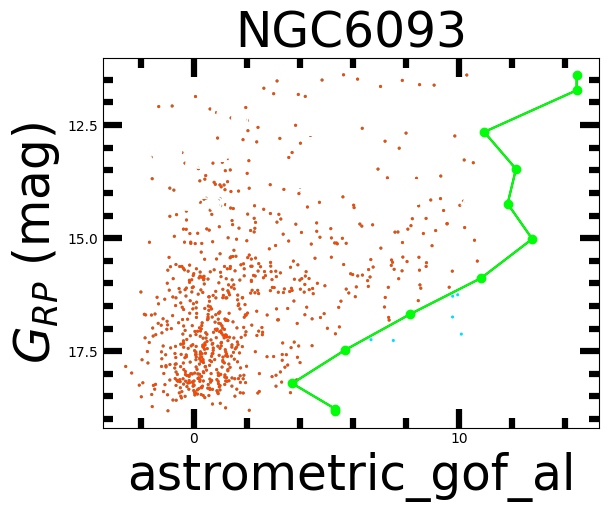

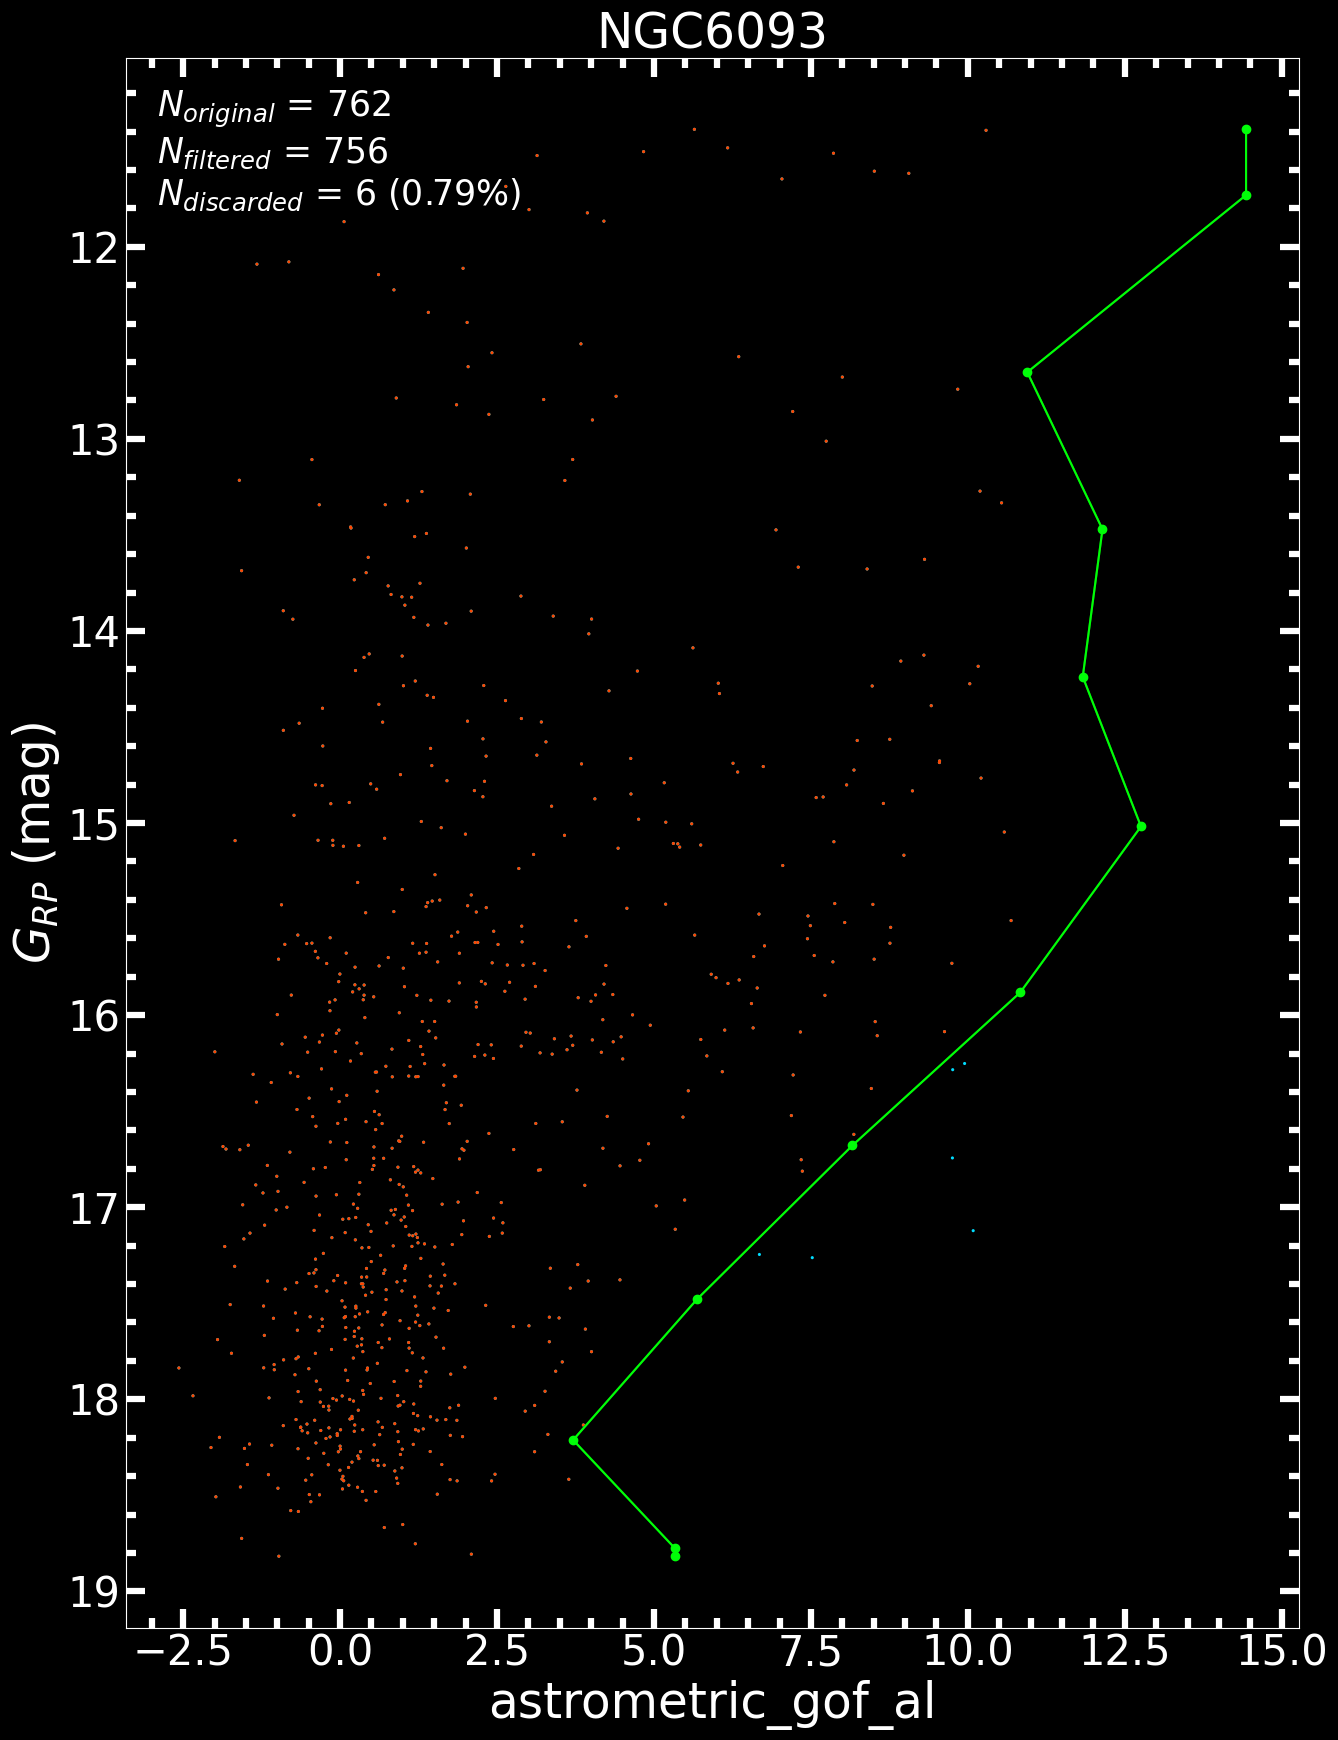

In [10]:
# You might need to run this cell twice to display the plot correctly...
# Plot the results after filtering by 'astrometric_gof_al' parameter
plotInterpolation(data_filtered_cordoni, gaia_data, points_as_gof_al,
                  'astrometric_gof_al', 'astrometric_gof_al')
# Plot twice since the first plot is not fully charged (Matplotlib's things)
plotInterpolation(data_filtered_cordoni, gaia_data, points_as_gof_al,
                  'astrometric_gof_al', 'astrometric_gof_al')

## 2.3 -. $\mu_R$ parameter

This parameter is defined as 
$$
  \mu_\text{R} = \sqrt{(\mu_\alpha \cos \alpha - \langle \mu_\alpha \cos \alpha \rangle)^2 + (\mu_\delta - \langle \mu_\delta \rangle)^2}
  $$

where $\mu_\delta$ and $\mu_\alpha \cos \delta$ are the proper motion components (extracted directly from Gaia DR3 as `pmra` and `pmdec` parameters), and $<\mu_\delta>$ and $< \mu_\alpha \cos \delta>$ are their mean values extracted from [Vasiliev & Baumgardt (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5978V/abstract) if the object is detected. Otherwise this mean value is set statistically and being changed/updated over iterations of this algorithm. 

In other words, $\mu_\text{R}$ is simply the distance of a point to the center of the ellipse defined in the step 2 in the Vector Point Diagram. Additionally, remember that we have previously filtered by any data with an error in $\mu_\delta$ or $\mu_\alpha \cos \delta$ bigger than $0.35 \ \text{mas} \cdot \text{yr}^{-1}$ in Step 1, i.e., we have aleady filtered for "noisy" data.

As we saw for the previous parameter, when we plot $G_{\rm RP}$ vs. $\mu_{\rm R}$, for the $n$th bin we will have a point located at:

$$ [\langle \mu_{\rm R} \rangle + 3 \cdot \sigma_{\mu_{\rm R}}, \ \langle G_{\rm RP} \rangle]_n$$

where $\langle \mu_{\rm R} \rangle$ is the median value for the $n$th bin and $\sigma_{\mu_{\rm R}}$ is the standard deviation for this value.

In [11]:
# Set the data/bins for the next filter
#totalCustomBins_muR = createBins(astrodata=data_filtered_by_as_gof_al, 
#                             nDivision=nDiv,
#                             printingBins=wantToPrintBins)

data_filtered_by_mu_R, points_mu_R = doAndPrintInterpolation(totalBins=totalCustomBins,
                                                               preData=data_filtered_cordoni,
                                                               len_originalData=len(data_filtered_by_as_gof_al),
                                                               varToInterpolate="mu_R",
                                                               sigma=Sigma)
data_filtered_cordoni = data_filtered_by_mu_R.copy()

Interpolating 'mu_R' parameter for a value of 3 σ...
##############################
Original data length (N): 756
Modified data length (N): 751
Data filtered/discarded: 0.66%


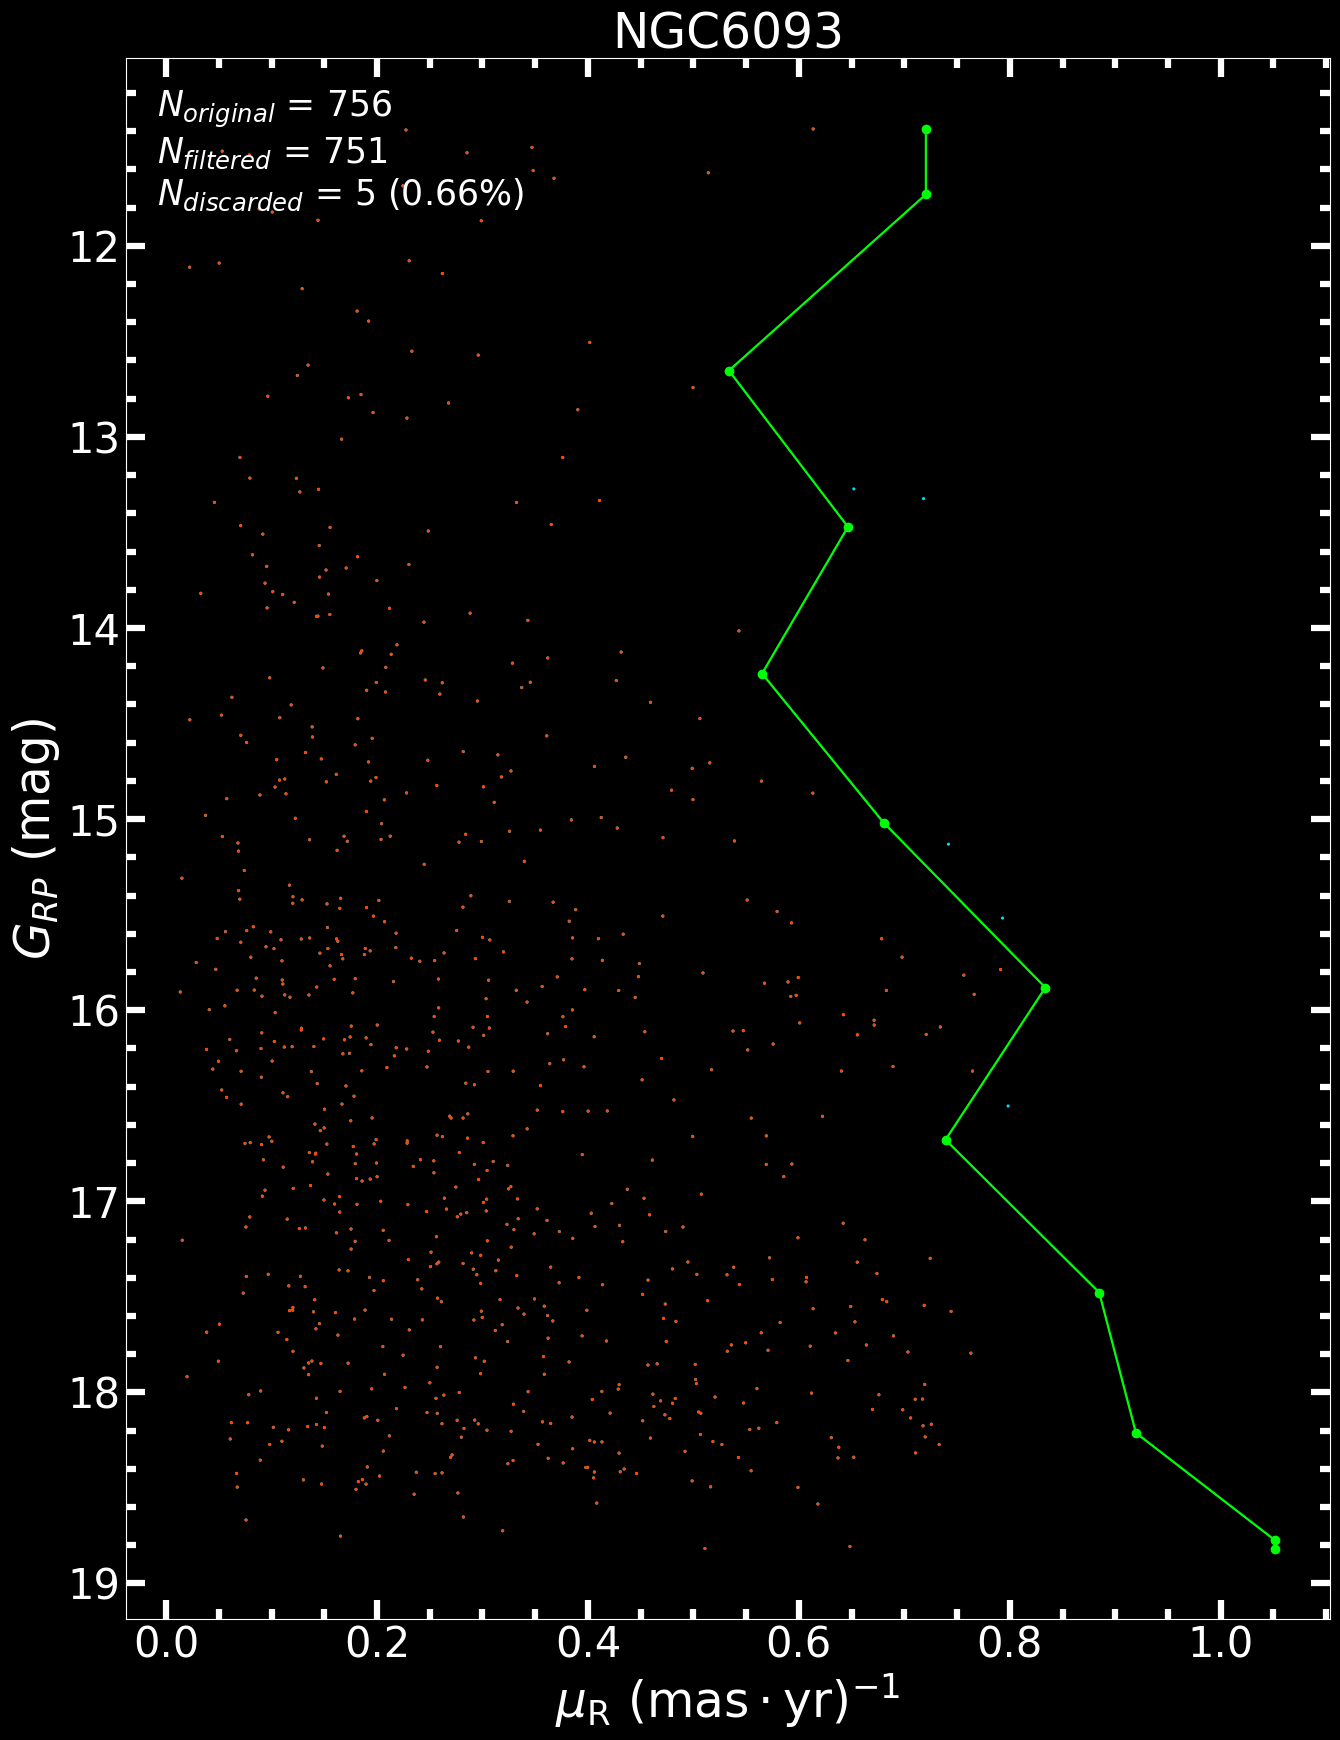

In [12]:
plotInterpolation(data_filtered_cordoni, data_filtered_by_as_gof_al, points_mu_R,
                  'mu_R', r"$\mu_{\rm R}$ $({\rm mas}\cdot{\rm yr})^{-1}$")

## 2.4-. Parallax ($\pi$) parameter

To extract objects that are at a similar distance from us, we also filter by parallax. However, we must notice that Gaia provides negative parallaxes. Based on the official [Gaia DR2 Documentation](https://gea.esac.esa.int/archive/documentation/GDR2/) (since this 'error' has been noticed from previous releases) we should notice the following:
- "For closely aligned sources (separated by $0.2 - 0.3$ arcsec), which are only occasionally resolved in the Gaia observations, confusion in the observation-to-source matching can lead to spurious parallax values which are either very large or have a negative value very far away from zero in terms of the formal parallax uncertainty quoted in the catalogue. These sources tend to be faint and located in crowded regions and are also associated with unreliable (large) proper motions (Gaia Collaboration et al. 2018b). Guidance on how to clean samples from spurious parallax values is provided in ".

However, removing all the "negative" parallaxes may lead to a significant bias in the data:
- "The systematic errors in the parallaxes are estimated to be below the $0.1$ mas level [Lindegren et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018A%26A...616A...2L/abstract) but the following systematics remain. There is an overall parallax zeropoint which, from an examination of QSO parallaxes, is estimated to be around $-0.03$ mas (in the sense of the Gaia DR2 parallaxes being too small). The estimated parallax zeropoint depends on the sample of sources examined [Arenou et al. 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...616A..17A/abstract) and the value above should not be used to ’correct’ the catalogue parallax values".

This is why, as an exception, when plotting $G_{\rm RP}$ vs. $\pi$ the $n$th bin will have 2 points located at:
$$ [\langle \pi \rangle \pm 3\cdot \sigma_\pi, \  \langle G_{\rm RP}\rangle]_n$$

where $\langle \pi \rangle$ is the median value for the $n$th bin and $\sigma_\pi$ is the standard deviation for this value.

In [13]:
# Set the data/bins for the next filter
#totalCustomBins_parallax = createBins(astrodata=data_filtered_by_mu_R, 
#                             nDivision=nDiv,
#                             printingBins=wantToPrintBins)

data_filtered_by_parallax, points_right, points_left = doAndPrintInterpolation(totalBins=totalCustomBins,
                                                               preData=data_filtered_cordoni,
                                                               len_originalData=len(data_filtered_by_mu_R),
                                                               varToInterpolate="parallax",
                                                               sigma=Sigma)
data_filtered_cordoni = data_filtered_by_parallax.copy()

Interpolating 'parallax' parameter for a value of 3 σ...
##############################
Original data length (N): 751
Modified data length (N): 738
Data filtered/discarded: 1.73%


And plot the result

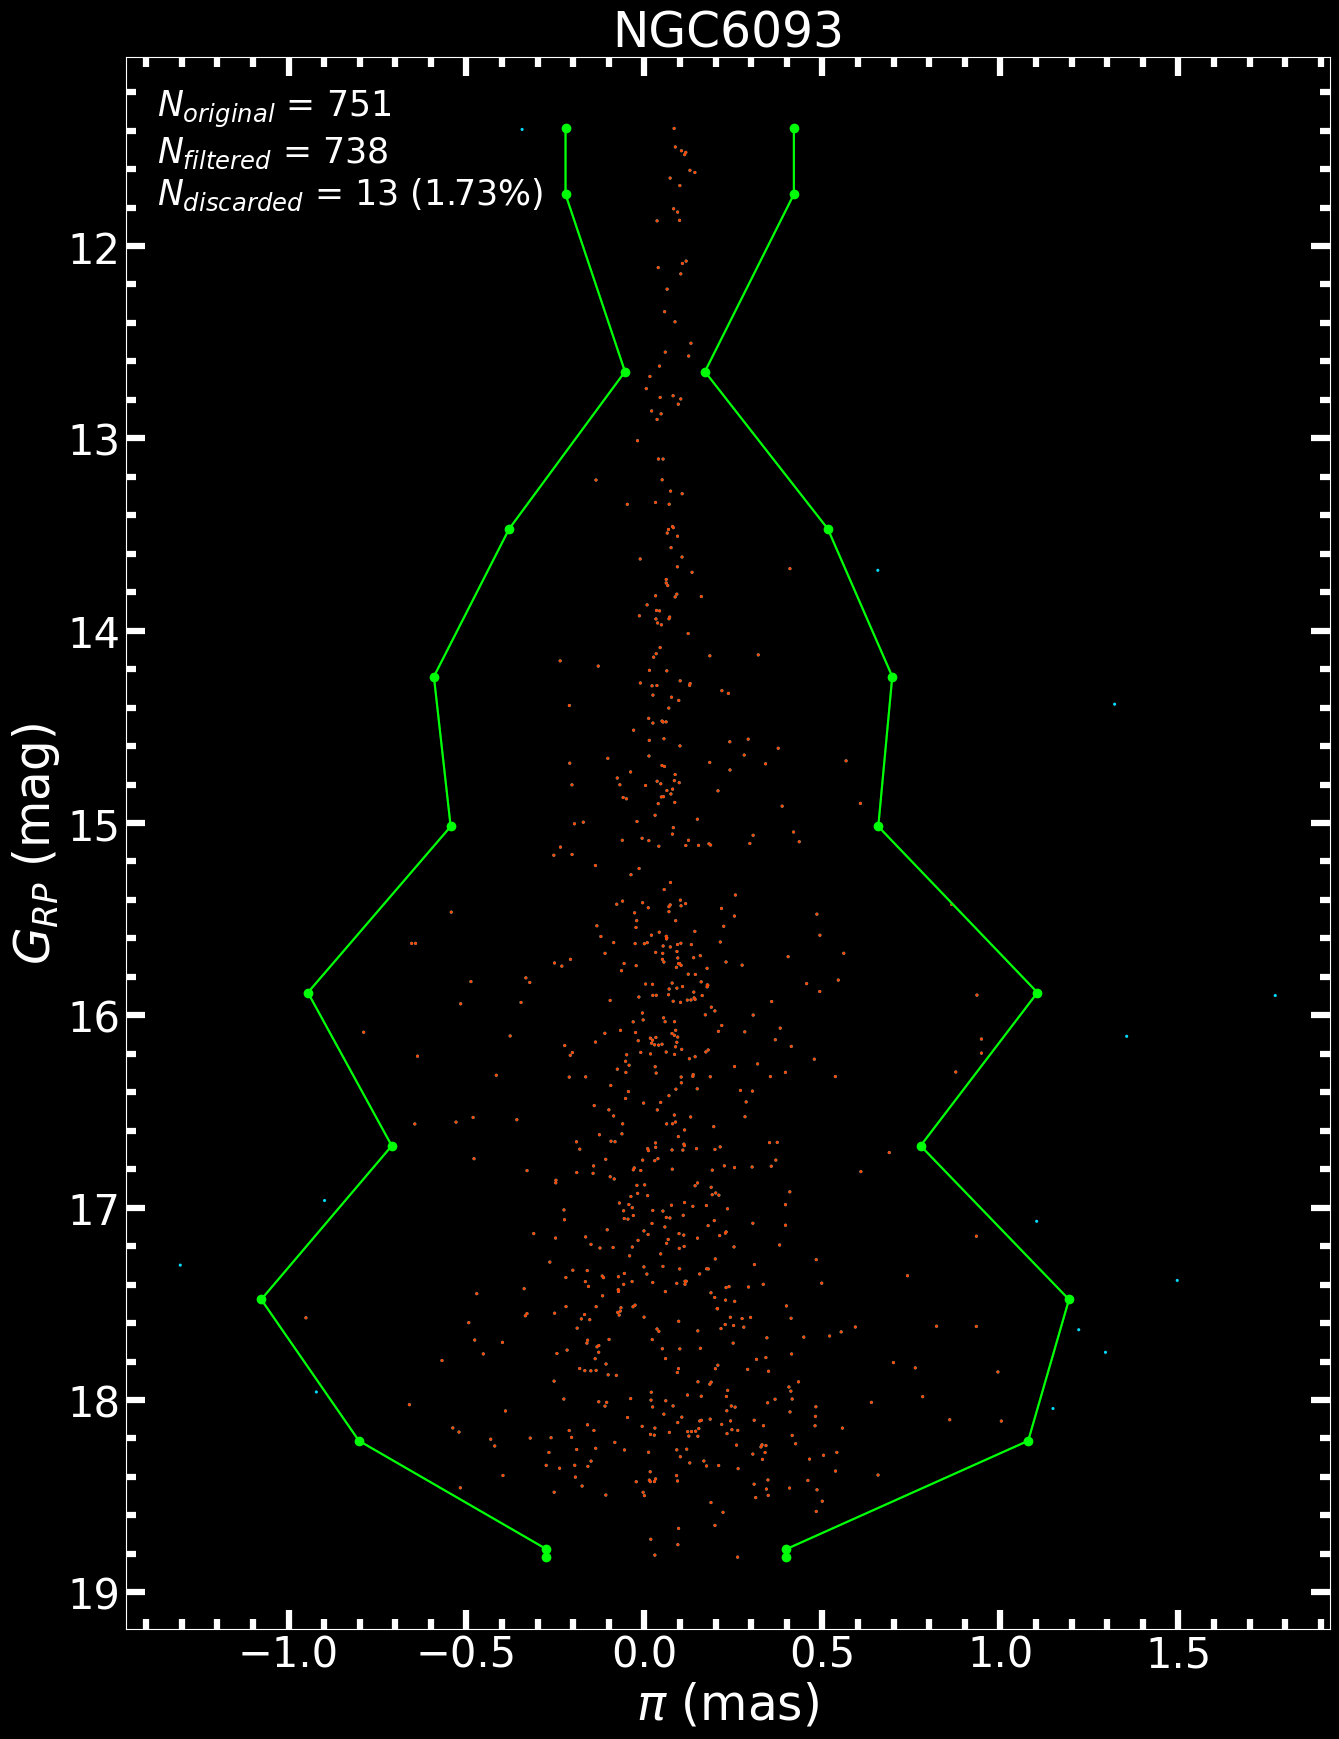

In [14]:
plotInterpolation(data_filtered_cordoni, data_filtered_by_mu_R, points_right,
                  'parallax', r"$\pi$ $({\rm mas})$", points_data_left=points_left)

Remember that in the first step we asked the user to enter the number of iterations (default 3). Now that we have succesfully done one iteration, do the rest

In [15]:
# Do N-1 iterations since we have already run one in the previous cells
for iteration in range (1, nIter):
    print(50*'#')
    print(f'[*] Iteration: {iteration}')
    # If the algorithm was previously run, use the latest filtered data as the new 'original'
    if iteration != 1:
        original_data_iteration = data_filtered_cordoni.copy()
    # If this is the first time running the algorithm, use the original data from ellipse/Gaia
    # defined in the previous step if this Notebook
    if iteration == 1:
        original_data_iteration = gaia_data.copy()
    
    data_filtered_cordoni = original_data_iteration.copy()
    # Filter by 'as_gof_al' parameter
    print("    Filtering by 'as_gof_al'")
    print(f"    Original data number: {len(data_filtered_cordoni)}")
    data_filtered_by_as_gof_al, points_as_gof_al = doAndPrintInterpolation(totalBins=totalCustomBins,
                                                                       preData=data_filtered_cordoni,
                                                                       # preData=gaia_data,
                                                                       len_originalData=len(gaia_data),
                                                                       varToInterpolate="astrometric_gof_al",
                                                                       sigma=Sigma)

    data_filtered_cordoni = data_filtered_by_as_gof_al.copy()
    print(f"    Data after filtering: {len(data_filtered_cordoni)}")
    
    print(50*'-')
    # Filter by 'mu_R' parameter
    print("    Filtering by 'mu_R'")
    print(f"    Original data number: {len(data_filtered_cordoni)}")
    data_filtered_by_mu_R, points_mu_R = doAndPrintInterpolation(totalBins=totalCustomBins,
                                                               preData=data_filtered_cordoni,
                                                               len_originalData=len(data_filtered_by_as_gof_al),
                                                               varToInterpolate="mu_R",
                                                               sigma=Sigma)
    data_filtered_cordoni = data_filtered_by_mu_R.copy()
    print(f"    Data after filtering: {len(data_filtered_cordoni)}")
    
    print(50*'-')
    # Filter by 'parallax' parameter
    print("    Filtering by 'parallax'")
    print(f"    Original data number: {len(data_filtered_cordoni)}")
    data_filtered_by_parallax, points_right, points_left = doAndPrintInterpolation(totalBins=totalCustomBins,
                                                               preData=data_filtered_cordoni,
                                                               len_originalData=len(data_filtered_by_mu_R),
                                                               varToInterpolate="parallax",
                                                               sigma=Sigma)
    data_filtered_cordoni = data_filtered_by_parallax.copy()
    print(f"    Data after filtering: {len(data_filtered_cordoni)}")
    print(50*'-')
    
print(f"Original Gaia data number (from Step 2): {len(gaia_data)}")
print(f"Data number after using Cordoni's algorithm: {len(data_filtered_cordoni)}")

##################################################
[*] Iteration: 1
    Filtering by 'as_gof_al'
    Original data number: 762
Interpolating 'astrometric_gof_al' parameter for a value of 3 σ...
##############################
Original data length (N): 762
Modified data length (N): 756
Data filtered/discarded: 0.79%
    Data after filtering: 756
--------------------------------------------------
    Filtering by 'mu_R'
    Original data number: 756
Interpolating 'mu_R' parameter for a value of 3 σ...
##############################
Original data length (N): 756
Modified data length (N): 751
Data filtered/discarded: 0.66%
    Data after filtering: 751
--------------------------------------------------
    Filtering by 'parallax'
    Original data number: 751
Interpolating 'parallax' parameter for a value of 3 σ...
##############################
Original data length (N): 751
Modified data length (N): 738
Data filtered/discarded: 1.73%
    Data after filtering: 738
--------------------------

In [16]:
# Read original raw data
if isGlobularCluster:
    filename_raw_path = f"../Objects/GlobularClusters/{object_name.lower().replace(' ','_')}/1_{object_name.lower().replace(' ','_')}_raw_data.dat"
if isOpenCluster:
    filename_raw_path = f"../Objects/OpenClusters/{object_name.lower().replace(' ','_')}/1_{object_name.lower().replace(' ','_')}_raw_data.dat"
if not isGlobularCluster and not isOpenCluster:
    filename_raw_path = f"../Objects/{object_name.lower().replace(' ','_')}/1_{object_name.lower().replace(' ','_')}_raw_data.dat"
    
# Check if the filtered file created in the previous step of this Notebook exists
check_if_file_exists(filename_raw_path)

original_data = Table.read(filename_raw_path, format='ascii.ecsv') # get data from previous Notebook step
print('[+] Data read sucessfully')

[+] Data read sucessfully


[+] Plot saved as '../Objects/GlobularClusters/ngc6093/3_ngc6093_CMD_final_data_dark_mode_show_legend.png'


<Figure size 1200x1600 with 0 Axes>

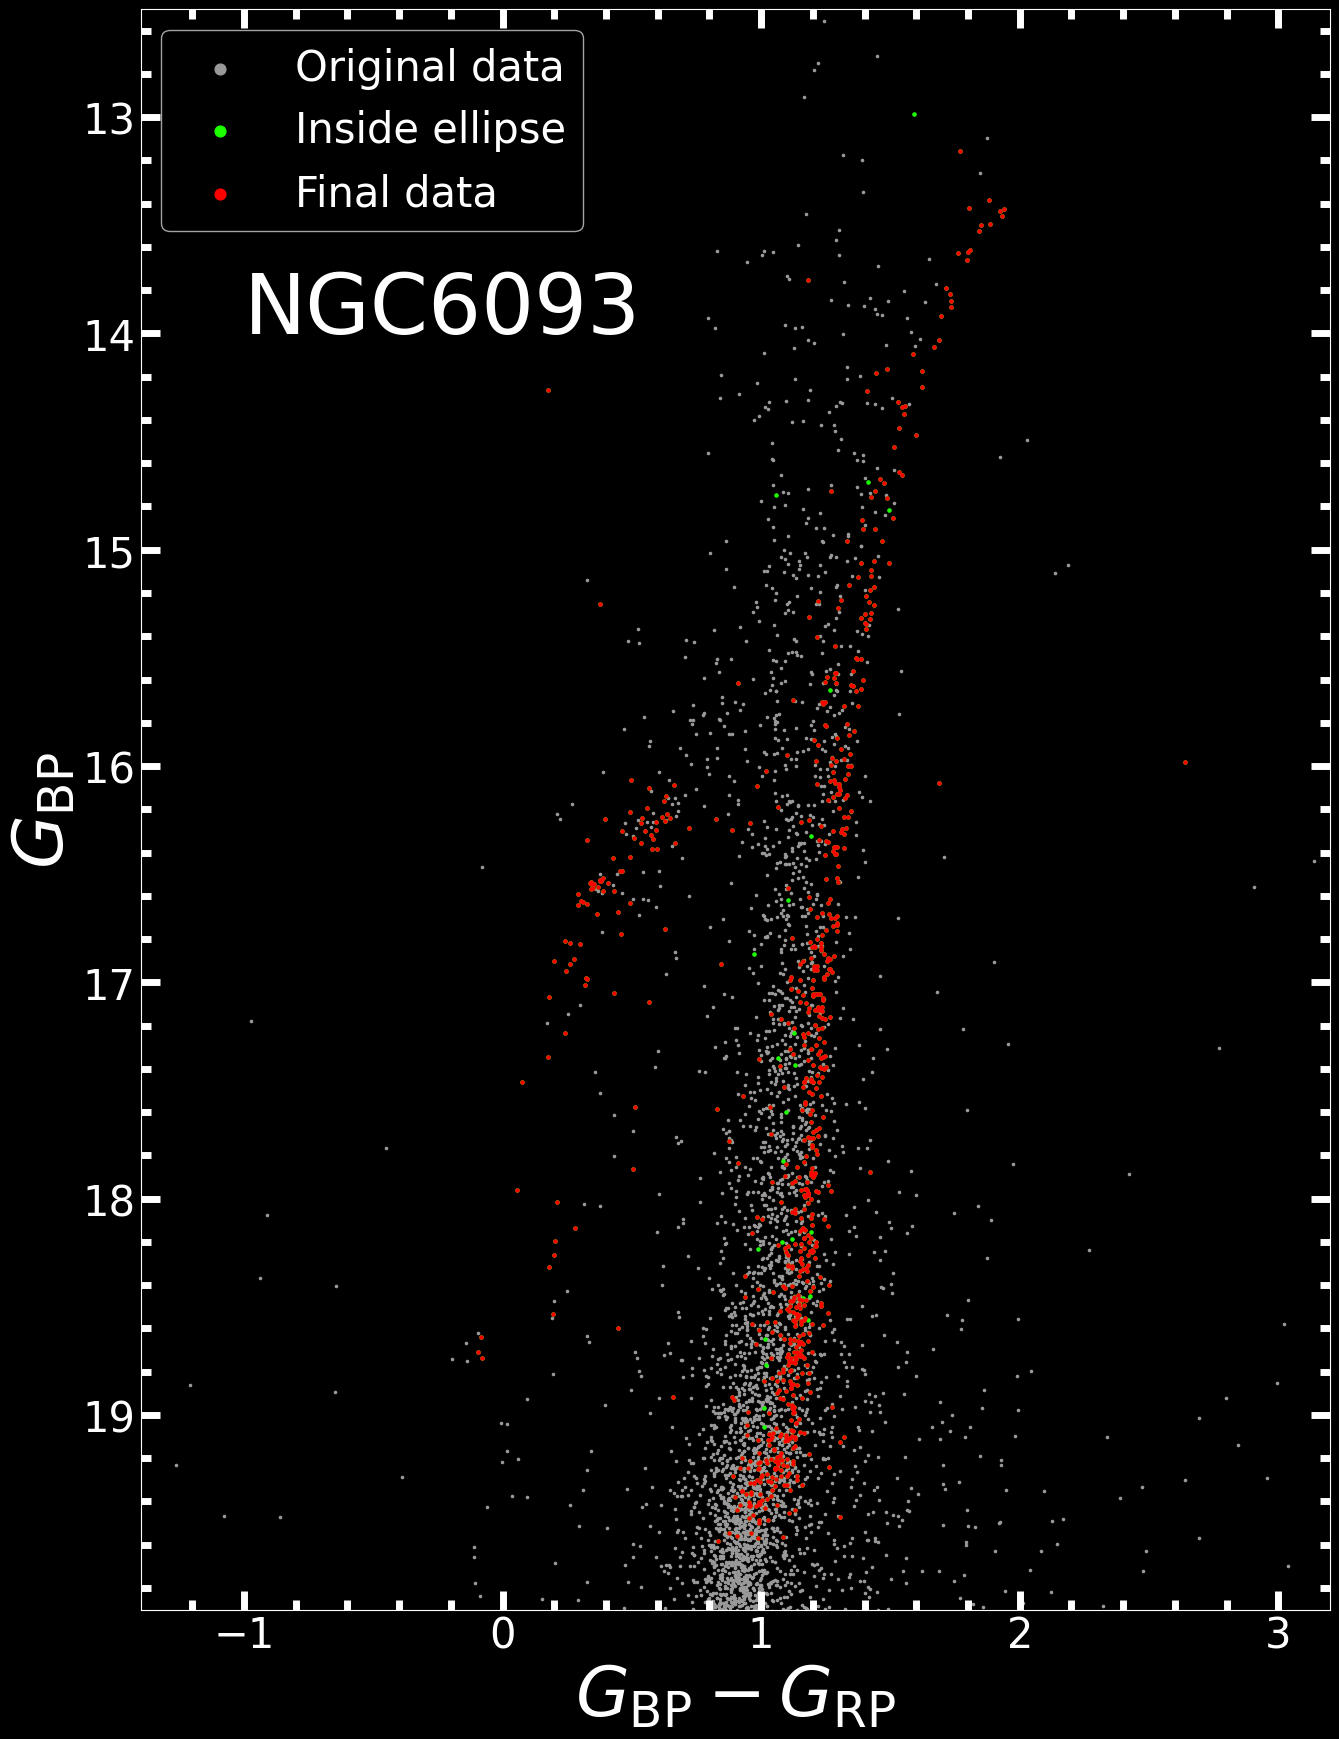

In [21]:
# Original raw data vs filtered data

wantToSaveCMD = False # do you want to save the plot generated?
format_img = 'png' # Format to save ('pdf', 'svg', 'png')
dark_mode = True # Display the plot in "dark mode"?
show_legend = False # Display legend/labels in the plot?

G_RP_original = original_data['phot_rp_mean_mag']
G_BP_original = original_data['phot_bp_mean_mag']

# Filtered data
G_RP = data_filtered_cordoni['phot_rp_mean_mag']
G_BP = data_filtered_cordoni['phot_bp_mean_mag']

if len(G_BP) < 100:
    scatter_size = 6.
    default_size = 2.5
else:
    scatter_size = 5.0
    default_size = 2.5
    
if dark_mode:
    color_original_data = "#999999"
    color_ellipse_data = "#1bff00"
    color_final_data = "#ff0000"
else:
    color_original_data = "#ffffff"
    color_ellipse_data = "#0073ca"
    color_final_data = "#ff1100"

plt.figure(figsize=(12, 16))
fig, ax = plt.subplots(1)
major_tick_size = 14
ax.tick_params(axis="y",direction="in", which='major', length=major_tick_size)
ax.tick_params(axis="y",direction="in", which='minor', length=major_tick_size/2.)
ax.tick_params(axis="x",direction="in", which='major', length=major_tick_size)
ax.tick_params(axis="x",direction="in", which='minor', length=major_tick_size/2.)
ax.tick_params(which='both', width=5)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
gaia_RP = gaia_data['phot_rp_mean_mag']
gaia_BP = gaia_data['phot_bp_mean_mag']
plt.xlabel(r'$G_{\rm BP} - G_{\rm RP}$', size=50)
plt.ylabel(r'$G_{\rm BP}$', size=50)
plt.gca().invert_yaxis()
# Original data
plt.scatter(G_BP_original-G_RP_original, G_BP_original, s = default_size, label = 'Original data', c = color_original_data)
# Data selected inside ellipse
plt.scatter(gaia_BP-gaia_RP , gaia_BP, s = scatter_size,label='Inside ellipse', c=color_ellipse_data)
# Final data
plt.scatter(G_BP-G_RP , G_BP, s = scatter_size, label='Final data', c=color_final_data)

if show_legend:
    lgnd = plt.legend(fontsize=30, markerscale=10.0)
    
    # Set the size of each marker to be equal
    for l in lgnd.legend_handles:
        l._sizes = [60]
    
plt.ylim(19.9, 12.5)
plt.xlim(-1.4, 3.2)
plt.text(-1., 14, f"{object_name.upper()}", fontsize=60)

if wantToSaveCMD:
    if isGlobularCluster:
        dir_path = f"../Objects/GlobularClusters/{object_name.lower().replace(' ','_')}/"
    if isOpenCluster:
        dir_path = f"../Objects/OpenClusters/{object_name.lower().replace(' ','_')}/"
    if not isGlobularCluster and not isOpenCluster:
        dir_path = f"../Objects/{object_name.lower().replace(' ','_')}/"
    save_filename = f"{dir_path}3_{object_name.lower().replace(' ', '_')}_CMD_final_data"
    if dark_mode:
        str_mode = "dark_mode"
        plt.style.use('dark_background')
    if not dark_mode:
        str_mode = "light_mode"
        plt.style.use('default')
    save_filename = f"{save_filename}_{str_mode}"
    if show_legend:
        str_legend = "show_legend"
    if not show_legend:
        str_legend = "no_legend"
    save_filename = f"{save_filename}_{str_legend}"
    # Finally, add the image format
    save_filename = f"{save_filename}.{format_img}"
    print(f"[+] Plot saved as '{save_filename}'")
    plt.savefig(save_filename, format=format_img, dpi=500.)

plt.show()
plt.close()

[+] Plot saved as '../Objects/GlobularClusters/ngc6093/3_ngc6093_VPD_final_data_dark_mode_show_legend.png'


<Figure size 1600x2200 with 0 Axes>

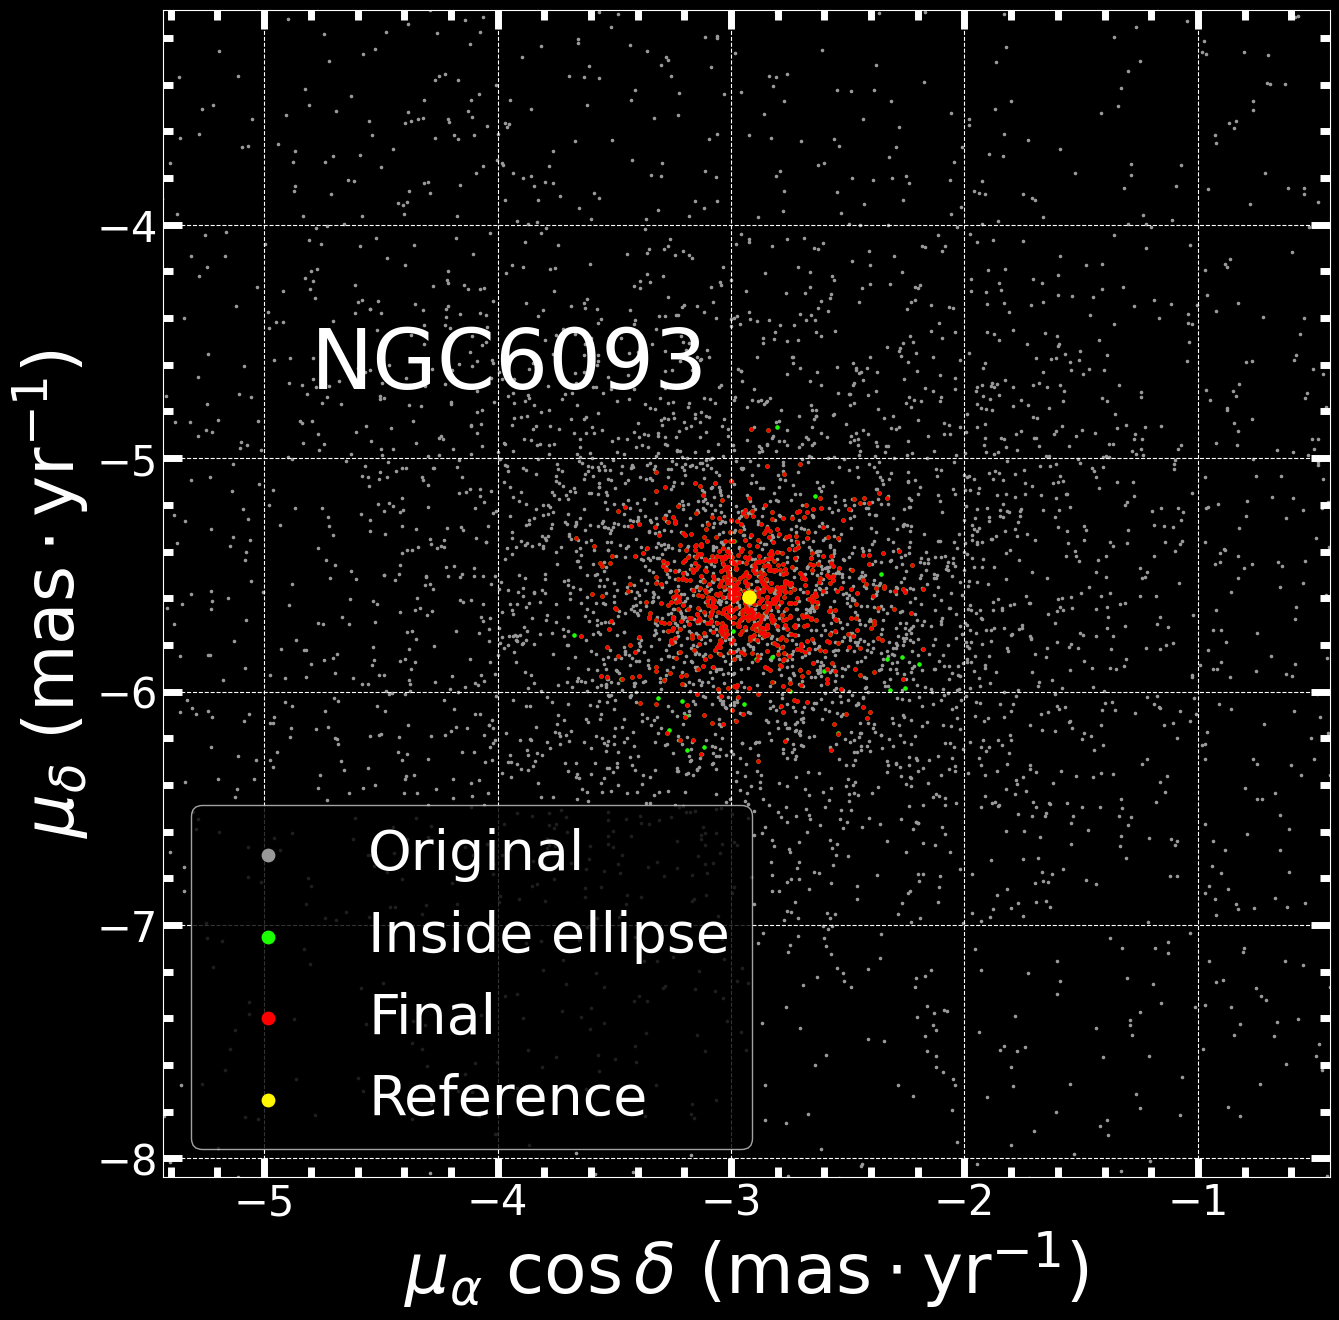

Total members: 738


In [26]:
wantToSaveVPD = False # Do you want to save the VPD generated?
format_img = 'png' # format to save the figure
dark_mode = True # Plot the figure in 'dark_mode'
show_legend = False # Show the legend/labels in the plot

#######

# Extract the values from diferent samples
# Filtered / final data
pmra = data_filtered_cordoni['pmra']
pmdec = data_filtered_cordoni['pmdec']
# Data from step 2 / inside ellipse
gaia_pmra = gaia_data['pmra']
gaia_pmdec = gaia_data['pmdec']
# Original raw data
original_pmra = original_data['pmra']
original_pmdec = original_data['pmdec']

if len(pmra) < 100:
    scatter_size = 8.
    default_size = 2.5
else:
    scatter_size = 5.0
    default_size = 2.5

if dark_mode:
    color_original_data = "#999999"
    color_ellipse_data = "#1bff00" 
    color_final_data = "#ff0000"
else:
    color_original_data = "#444444"
    color_ellipse_data = "#0073ca"
    color_final_data = "#ff1100"

plt.figure(figsize=(16, 22))
fig, ax = plt.subplots(1)
ax.set_aspect('equal')
major_tick_size = 14
ax.tick_params(axis="y",direction="in", which='major', length=major_tick_size)
ax.tick_params(axis="y",direction="in", which='minor', length=major_tick_size/2.)
ax.tick_params(axis="x",direction="in", which='major', length=major_tick_size)
ax.tick_params(axis="x",direction="in", which='minor', length=major_tick_size/2.)
ax.tick_params(which='both', width=5)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()    
plt.ylabel(r'$\mu_\delta$ $({\rm mas} \cdot {\rm yr}^{-1})$', size = 50)
plt.xlabel(r'$\mu_\alpha \ \cos \delta$ $({\rm mas} \cdot {\rm yr}^{-1})$', size = 50)
# Original data
plt.scatter(original_pmra, original_pmdec, s = default_size, c=color_original_data, label = "Original")
# Inside ellipse/step 2 data
plt.scatter(gaia_pmra, gaia_pmdec, s = scatter_size,label='Inside ellipse', c=color_ellipse_data)
# Final data
plt.scatter(pmra , pmdec, s = scatter_size,label='Final', c=color_final_data)
# Plot the median PM found in Vasiliev & Baumgardt (2021) or Cantat-Gaudin et al. (2020)
plt.scatter(np.median(gaia_pmra), np.median(gaia_pmdec), c="#fff800", s=90, label = "Reference")
if show_legend:
    lgnd = plt.legend(fontsize=40, markerscale=10.0)
    # Set the size of each marker to be equal
    for l in lgnd.legend_handles:
        l._sizes = [80]
#plt.xlim(-1.5, 8.5)
plt.xlim(object_data_obtained.pmra-2.5, object_data_obtained.pmra+2.5)
#plt.xlim(-1.5, 8.5)
plt.ylim(object_data_obtained.pmdec-2.5, object_data_obtained.pmdec+2.5)
plt.grid(linestyle='--')
#plt.text(-4.8, -4.7, f"{object_name.upper()}", fontsize=60)

if wantToSaveVPD:
    # Choose the object type
    if isGlobularCluster:
        dir_path = f"../Objects/GlobularClusters/{object_name.lower().replace(' ','_')}/"
    if isOpenCluster:
        dir_path = f"../Objects/OpenClusters/{object_name.lower().replace(' ','_')}/"
    if not isGlobularCluster and not isOpenCluster:
        dir_path = f"../Objects/{object_name.lower().replace(' ','_')}/"
    save_filename = f"{dir_path}3_{object_name.lower().replace(' ', '_')}_VPD_final_data"
    # Save plot in dark mode
    if dark_mode:
        plt.style.use('dark_background')
        str_mode = "dark_mode"
    if not dark_mode:
        str_mode = "light_mode"
    save_filename = f"{save_filename}_{str_mode}"
    # Display legend (labels)
    if show_legend:
        str_legend = "show_legend"
    if not show_legend:
        str_legend = "no_legend"
    save_filename = f"{save_filename}_{str_legend}"
    # Add format to save the image
    save_filename = f"{save_filename}.{format_img}"
    print(f"[+] Plot saved as '{save_filename}'")
    plt.savefig(save_filename, format=format_img, dpi=400.)

plt.show()
plt.close()
print(f"Total members: {len(pmra)}")

# Save the data
Finally, save the data. If your object was a Globular Cluster or an Open Cluster, these stars should be members of the cluster. You can compare them with different catalogs like [Vasiliev & Baumgardt (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5978V/abstract) for Globular Clusters or [Cantat-Gaudin et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020A%26A...640A...1C/abstract) for Open Clusters.

In [19]:
if isGlobularCluster:
    dir_path = f"../Objects/GlobularClusters/{object_name.lower().replace(' ','_')}/"
if isOpenCluster:
    dir_path = f"../Objects/OpenClusters/{object_name.lower().replace(' ','_')}/"
if not isGlobularCluster and not isOpenCluster:
    dir_path = f"../Objects/{object_name.lower().replace(' ','_')}/"
save_filename = f"3_{object_name.lower().replace(' ', '_')}_f_data.dat"
print("[+] Writing files. Please wait...")
data_filtered_cordoni.write(f"{dir_path}{save_filename}", format='ascii.ecsv', overwrite=True)
print("\n[+] Done!")

[+] Writing files. Please wait...

[+] Done!
